In [1]:
# in use of torch_env:3.9.19 #
# double the run to avoid duplicate of 'inline' #

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import time
import torch
import jsonlines
import qianfan
from ollama import chat
from ollama import ChatResponse
from ollama import Client
from datetime import datetime, timedelta

[WARNING][2025-04-02 20:09:39.659] redis_rate_limiter.py:21 [t:38668]: No redis installed, RedisRateLimiter unavailable. Ignore this warning if you don't need to use qianfan SDK in distribution environment


# Sample data

In [2]:
# 读取 Excel 文件（请替换 'data.xlsx' 为你的文件路径）
df_sample = pd.read_excel("merged_data_base.xlsx").head(20)
df_sample_new = df_sample.reset_index()

In [3]:
df_all = pd.read_excel("merged_data_base.xlsx")
df_all_new = df_all.reset_index()

# Data filter

In [4]:
def filter_chinese_phrase(df, column_name, phrase_list):
    """
    在DataFrame的指定列中筛选出包含phrase_list中任意一个词的行。

    :param df: 输入的DataFrame
    :param column_name: 需要筛选的列名
    :param phrase_list: 包含需要筛选的短语的列表
    :return: 筛选后的DataFrame
    """
    # 将指定列的值转换为字符串类型
    df[column_name] = df[column_name].astype(str)
    
    # 使用apply函数和lambda表达式来检查每一行是否包含phrase_list中的任意一个词
    filtered_df = df[df[column_name].apply(lambda x: any(phrase in x for phrase in phrase_list))]
    return filtered_df

phrase_list = ["物料","采购","竞争","激励","供应","意外","风险","现代化","民主","发展","反腐","系统","安全","创新"]
filtered_df = filter_chinese_phrase(df_all_new, '新闻内容', phrase_list)

filtered_df['发布时间'] = pd.to_datetime(filtered_df['发布时间'])
start_date = pd.Timestamp('2024-11-18')
end_date = pd.Timestamp('2024-12-26')
filtered_df = filtered_df[(filtered_df['发布时间'] >= start_date) & (filtered_df['发布时间'] <= end_date)]

exclude_dates = [
    '2024-11-23', '2024-11-24', '2024-11-30',
    '2024-12-01', '2024-12-07', '2024-12-08',
    '2024-12-14', '2024-12-15', '2024-12-21', '2024-12-22'
]

exclude_dates = pd.to_datetime(exclude_dates)
final_df = filtered_df[~filtered_df['发布时间'].dt.floor('d').isin(exclude_dates)]

C:\Users\Pratt\AppData\Local\Temp\ipykernel_34124\3016342246.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['发布时间'] = pd.to_datetime(filtered_df['发布时间'])


# Final Data Store & Loading

In [ ]:
final_df.to_excel("final_selection.xlsx", index=False)

In [5]:
def save_list_to_json(data, filename):
    """
    将 Python List 存储为 JSON 文件

    参数:
        data (list): 要存储的 List 数据
        filename (str): 保存的文件名（可以包含路径）
    """
    try:
        # 确保目录存在
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        
        # 将 List 保存为 JSON 文件
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)
        print(f"数据已成功保存到 {filename}")
    except Exception as e:
        print(f"保存文件时出错: {e}")

In [6]:
def load_list_from_json(filename):
    """
    从 JSON 文件加载 List 数据

    参数:
        filename (str): 要加载的文件名（可以包含路径）

    返回:
        list: 加载的 List 数据
    """
    try:
        # 从 JSON 文件加载数据
        with open(filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"数据已成功从 {filename} 加载")
        return data
    except Exception as e:
        print(f"加载文件时出错: {e}")
        return None


In [7]:
news_final_df = pd.read_excel("final_selection.xlsx")
news_final_df['关键词'] = news_final_df['关键词'].apply(lambda x:str(x).zfill(6))

In [8]:
news_final_df

,index,关键词,新闻标题,新闻内容,发布时间,文章来源,新闻链接
0,39936,600816,维信金科CTO史红哲：以场景探索驱动维信大模型应用发展,从维信金科的实践来看，其合作机构多是地方中小银行，在提升客户服务体验和效率、增强获客能力、强...,2024-11-18 00:14:34,21世纪经济报道,http://finance.eastmoney.com/a/202411183241837...
1,39937,002373,维信金科CTO史红哲：以场景探索驱动维信大模型应用发展,据介绍，为此，维信金科研发了昆仑镜智能风控系统，该系统通过智能风险识别，基于征信大数据等标准...,2024-11-18 00:14:34,21世纪经济报道,http://finance.eastmoney.com/a/202411183241837...
2,39938,688387,维信金科CTO史红哲：以场景探索驱动维信大模型应用发展,从维信金科的实践来看，其合作机构多是地方中小银行，在提升客户服务体验和效率、增强获客能力、强...,2024-11-18 00:14:34,21世纪经济报道,http://finance.eastmoney.com/a/202411183241837...
3,39942,603056,高德红外多项硬核装备亮相2024珠海航展,同时，GAM系列反坦克DD还列入中央军委装备发展部军贸装备谱系产品进行展示，彰显高德红外在国...,2024-11-18 00:30:57,每日经济新闻,http://finance.eastmoney.com/a/202411183241838...
4,39944,002414,高德红外多项硬核装备亮相2024珠海航展,同时，GAM系列反坦克DD还列入中央军委装备发展部军贸装备谱系产品进行展示，彰显高德红外在国...,2024-11-18 00:30:57,每日经济新闻,http://finance.eastmoney.com/a/202411183241838...
...,...,...,...,...,...,...,...
12697,118141,300285,山东矿机：公司生产经营活动一切正常,山东矿机（002526.SZ）12月25日在投资者互动平台表示，您好，公司生产经营活动一切正...,2024-12-25 23:11:36,每日经济新闻,http://finance.eastmoney.com/a/202412253279157...
12698,118142,600350,山东矿机：公司生产经营活动一切正常,山东矿机（002526.SZ）12月25日在投资者互动平台表示，您好，公司生产经营活动一切正...,2024-12-25 23:11:36,每日经济新闻,http://finance.eastmoney.com/a/202412253279157...
12699,118143,688234,山东矿机：公司生产经营活动一切正常,山东矿机（002526.SZ）12月25日在投资者互动平台表示，您好，公司生产经营活动一切正...,2024-12-25 23:11:36,每日经济新闻,http://finance.eastmoney.com/a/202412253279157...
12700,118145,601615,熵基科技：公司的AI数字标牌主要应用在智慧零售场景,公司的AI数字标牌主要应用在智慧零售场景。公司将持续保持对国内外最新先进技术的关注，坚持自主...,2024-12-25 23:11:40,每日经济新闻,http://finance.eastmoney.com/a/202412253279158...


# Points Generation

1.  ernie-lite-8k

In [ ]:
#通过环境变量初始化认证信息
# 方式一：【推荐】使用安全认证AK/SK鉴权
# 替换下列示例中参数，安全认证Access Key替换your_iam_ak，Secret Key替换，your_iam_sk，如何获取请查看https://cloud.baidu.com/doc/Reference/s/9jwvz2egb
os.environ["QIANFAN_ACCESS_KEY"] = "ac"
os.environ["QIANFAN_SECRET_KEY"] = "sec"

# 方式二：【不推荐】使用应用AK/SK鉴权
# 替换下列示例中参数，将应用API_Key、应用Secret key值替换为真实值，如何获取请参考https://cloud.baidu.com/doc/WENXINWORKSHOP/s/Fllg87pck
#os.environ["QIANFAN_AK"] = "应用API_Key"
#os.environ["QIANFAN_SK"] = "应用Secret_Key"

chat_comp = qianfan.ChatCompletion()
answer_ERNIE = []

for _, row in news_final_df.iloc[:4000].iterrows():
    index = row["index"]  
    field_data = row["新闻内容"]  
    question = f"""请你阅读这段文字：{field_data} 。请直接返回一个列表告诉我这段文字在公司治理方向的情绪分数，格式如下："```\n['本文在公司治理方向的情绪分数':'X']\n```"，其中 X 为 1，2，3，4，5，6，7，8，9 之中的某个数字，数字越大说明越正向，无关公司治理的内容标注为数字0。一定不要返回其余解释。"""
    while True:
        try:
            # 指定特定模型
            resp = chat_comp.do(model="ernie-lite-8k", messages=[{
                "role": "user",
                "content": question
            }])
            answer_ERNIE.append(resp["body"]['result'])
            break  # 成功处理当前行，跳出重试循环
        except Exception as e:
            print(f"处理 index {index} 时出错: {e}，正在重试...")

In [ ]:
for _, row in news_final_df.iloc[4000:8000].iterrows():
    index = row["index"]  
    field_data = row["新闻内容"]  
    question = f"""请你阅读这段文字：{field_data} 。请直接返回一个列表告诉我这段文字在公司治理方向的情绪分数，格式如下："```\n['本文在公司治理方向的情绪分数':'X']\n```"，其中 X 为 1，2，3，4，5，6，7，8，9 之中的某个数字，数字越大说明越正向，无关公司治理的内容标注为数字0。一定不要返回其余解释。"""
    while True:
        try:
            # 指定特定模型
            resp = chat_comp.do(model="ernie-lite-8k", messages=[{
                "role": "user",
                "content": question
            }])
            answer_ERNIE.append(resp["body"]['result'])
            break  # 成功处理当前行，跳出重试循环
        except Exception as e:
            print(f"处理 index {index} 时出错: {e}，正在重试...")

In [ ]:
for _, row in news_final_df.iloc[8000:12000].iterrows():
    index = row["index"]  
    field_data = row["新闻内容"]  
    question = f"""请你阅读这段文字：{field_data} 。请直接返回一个列表告诉我这段文字在公司治理方向的情绪分数，格式如下："```\n['本文在公司治理方向的情绪分数':'X']\n```"，其中 X 为 1，2，3，4，5，6，7，8，9 之中的某个数字，数字越大说明越正向，无关公司治理的内容标注为数字0。一定不要返回其余解释。"""
    while True:
        try:
            # 指定特定模型
            resp = chat_comp.do(model="ernie-lite-8k", messages=[{
                "role": "user",
                "content": question
            }])
            answer_ERNIE.append(resp["body"]['result'])
            break  # 成功处理当前行，跳出重试循环
        except Exception as e:
            print(f"处理 index {index} 时出错: {e}，正在重试...")

In [ ]:
for _, row in news_final_df.iloc[12000:].iterrows():
    index = row["index"]  
    field_data = row["新闻内容"]  
    question = f"""请你阅读这段文字：{field_data} 。请直接返回一个列表告诉我这段文字在公司治理方向的情绪分数，格式如下："```\n['本文在公司治理方向的情绪分数':'X']\n```"，其中 X 为 1，2，3，4，5，6，7，8，9 之中的某个数字，数字越大说明越正向，无关公司治理的内容标注为数字0。一定不要返回其余解释。"""
    while True:
        try:
            # 指定特定模型
            resp = chat_comp.do(model="ernie-lite-8k", messages=[{
                "role": "user",
                "content": question
            }])
            answer_ERNIE.append(resp["body"]['result'])
            break  # 成功处理当前行，跳出重试循环
        except Exception as e:
            print(f"处理 index {index} 时出错: {e}，正在重试...")

In [ ]:
# 保存 List 到 JSON 文件
save_list_to_json(answer_ERNIE, ".\\points_data\\Erine_lite_8k_full.json")

2.  Deepseek-r1-7b

In [ ]:
# stream response # 
# 调用本地的性能进行 #

answer_Deepseek = []

for _, row in news_final_df.iterrows():
    index = row["index"]  
    field_data = row["新闻内容"]  
    question = f"""请你阅读这段文字：{field_data} 。请直接返回一个列表告诉我这段文字在公司治理方向的情绪分数，格式如下："```\n['本文在公司治理方向的情绪分数':'X']\n```"，其中 X 为 1，2，3，4，5，6，7，8，9 之中的某个数字，数字越大说明越正向，无关公司治理的内容标注为数字0。一定不要返回其余解释。"""

    # 指定特定模型
    stream = chat(
        model='deepseek-r1:7b',
        messages=[{'role': 'user', 
                  'content': question}],
        stream=False,
    )
    answer_Deepseek.append(stream['message']['content'])

In [ ]:
# cuda memory free
import torch
torch.cuda.empty_cache()

In [ ]:
# 保存 List 到 JSON 文件
save_list_to_json(answer_Deepseek, ".\\points_data\\Deepseek_r1_7B_full.json")

3. spark-lite

In [ ]:
from sparkai.llm.llm import ChatSparkLLM, ChunkPrintHandler
from sparkai.core.messages import ChatMessage

#星火认知大模型Spark Max的URL值，其他版本大模型URL值请前往文档（https://www.xfyun.cn/doc/spark/Web.html）查看
SPARKAI_URL = 'wss://spark-api.xf-yun.com/v1.1/chat'
#星火认知大模型调用秘钥信息，请前往讯飞开放平台控制台（https://console.xfyun.cn/services/bm35）查看
SPARKAI_APP_ID = 'id'
SPARKAI_API_SECRET = 'secd'
SPARKAI_API_KEY = 'key'
#星火认知大模型Spark Max的domain值，其他版本大模型domain值请前往文档（https://www.xfyun.cn/doc/spark/Web.html）查看
SPARKAI_DOMAIN = 'lite'

spark = ChatSparkLLM(
    spark_api_url=SPARKAI_URL,
    spark_app_id=SPARKAI_APP_ID,
    spark_api_key=SPARKAI_API_KEY,
    spark_api_secret=SPARKAI_API_SECRET,
    spark_llm_domain=SPARKAI_DOMAIN,
    streaming=False,
)


def split_and_call(news_final_df, chunk_size=1, delay=0.5):
    """
    拆分 DataFrame 并控制调用间隔，支持无限重试
    :param news_final_df: 原始 DataFrame
    :param chunk_size: 每个小块的大小
    :param delay: 每组调用之间的间隔时间（秒）
    :return: 包含所有结果的列表
    """
    answer_Spark = []
    # 将 DataFrame 拆分成多个小块
    chunks = [news_final_df[i:i + chunk_size] for i in range(0, len(news_final_df), chunk_size)]
    for chunk in chunks:
        while True:  # 无限重试，直到成功处理当前 chunk
            try:
                chunk_answer = []  # 用于存储当前 chunk 的结果
                for _, row in chunk.iterrows():
                    index = row["index"]  
                    field_data = row["新闻内容"]  
                    question = f"""请你阅读这段文字：{field_data} 。请直接返回一个列表告诉我这段文字在公司治理方向的情绪分数，格式如下："```\n['本文在公司治理方向的情绪分数':'X']\n```"，其中 X 为 1，2，3，4，5，6，7，8，9 之中的某个数字，数字越大说明越正向，无关公司治理的内容标注为数字0。一定不要返回其余解释。"""
                    messages = [ChatMessage(
                        role="user",
                        content=question
                    )]
                    handler = ChunkPrintHandler()
                    a = spark.generate([messages], callbacks=[handler])
                    sparkre_body = a.generations[0][0].__dict__
                    chunk_answer.append(sparkre_body['text'])  # 将结果添加到 chunk_answer
                # 如果整个 chunk 处理成功，将其结果添加到 answer_Spark
                answer_Spark.extend(chunk_answer)
                break  # 跳出重试循环，继续处理下一个 chunk
            except Exception as e:
                print(f"处理 chunk 时出错: {e}，正在重试...")
                time.sleep(delay)  # 重试前等待一段时间
        # 每组调用完成后延时10秒
        time.sleep(delay)
    return answer_Spark

In [ ]:
# 使用示例
answer_Spark = split_and_call(news_final_df, chunk_size=1, delay=0.5)

In [ ]:
# 保存 List 到 JSON 文件
save_list_to_json(answer_Spark, ".\\points_data\\Spark_lite_full.json")

4. llama-3.2-3b

In [ ]:
# stream response # 
# 调用本地的性能进行 #

answer_llama = []

for _, row in news_final_df.iterrows():
    index = row["index"]  
    field_data = row["新闻内容"]  
    question = f"""Please read this article:{field_data}. Please directly return a list to tell me the sentiment score in Governance factor of the given article, with a solid format as: "```\n['The sentiment score in governance factor':'X']\n```", here X is a number in 1,2,3,4,5,6,7,8,9, larger the number, more postivive the sentiment, and if the article is no related to the governance factor, the X is 0. Do not return any other word explanations."""

    # 指定特定模型
    stream = chat(
        model='llama3.2:3b',
        messages=[{'role': 'user', 
                  'content': question}],
        stream=False,
    )
    answer_llama.append(stream['message']['content'])

In [ ]:
# 保存 List 到 JSON 文件
save_list_to_json(answer_llama, ".\\points_data\\Llama3_3B_full.json")

5. finbert_1_2019： special model since the ability to develop (sentiment analysis) (ban)

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [ ]:
# 假设df_sample_new是已有的DataFrame
finbert_results = []

# 检查是否有可用的CUDA设备
device = torch.device('cuda')

# 将模型移动到GPU
finbert_model.to(device)

for _, row in filtered_df.iterrows():
    text = row["新闻内容"]
    
    # 处理文本并生成模型输入
    inputs = finbert_tokenizer(text, padding=True, truncation=True, max_length=100000, return_tensors="pt")
    
    # 将输入数据移动到GPU
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # 模型推理
    with torch.no_grad():
        outputs = finbert_model(**inputs)
    
    # 定义标签到分数的映射
    label_mapping = {
        'positive': 8,
        'neutral': 5,
        'negative': 2
    }
    
    # 获取预测标签和对应分数
    predicted_label = finbert_model.config.id2label[torch.argmax(outputs.logits).item()]
    score = label_mapping.get(predicted_label)  # 默认中性分数为5
    
    # 将结果存入指定格式
    finbert_results.append(f"```\n['本文在公司治理方向的情绪分数':'{outputs,score}']\n```")

6. finbert_hkust:pretrained fill-mask model. (ban)

In [ ]:
from transformers import AutoModelForMaskedLM, AutoTokenizer

# 加载预训练模型和分词器
finbert_hkust_model_name = "yiyanghkust/finbert-pretrain"
finbert_hkust_model = AutoModelForMaskedLM.from_pretrained(finbert_hkust_model_name)
finbert_hkust_tokenizer = AutoTokenizer.from_pretrained(finbert_hkust_model_name)

finbert_hkust_results = []

# 检查是否有可用的CUDA设备
device = torch.device('cuda')

# 将模型移动到GPU
finbert_hkust_model.to(device)

for _, row in df_sample_new.iterrows():
    field_data = row["新闻内容"]
    question = f"""Please read this article:{field_data}. Please directly return a list to tell me the sentiment score in Governance factor of the given article. Score is a number in 1,2,3,4,5,6,7,8,9, larger the number, more postivive the sentiment, and if the article is no related to the governance factor, the score is 0. By your judge, the score is [MASK]."""
    # 处理文本并生成模型输入
    inputs = finbert_hkust_tokenizer(question, padding=True, truncation=True, max_length=100000, return_tensors="pt")

    # 将输入数据移动到GPU
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # 预测结果
    with torch.no_grad():
        outputs = finbert_hkust_model(**inputs)

    # 获取预测结果
    predictions = outputs.logits
    masked_index = torch.where(inputs["input_ids"][0] == finbert_hkust_tokenizer.mask_token_id)[0]
    predicted_token_id = torch.argmax(predictions[0, masked_index]).item()
    score = finbert_hkust_tokenizer.decode(predicted_token_id)
    
    # 将结果存入指定格式
    finbert_hkust_results.append(score)

7. DISC-FinLLM:large scale analysis(ban)

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.generation.utils import GenerationConfig

tokenizer = AutoTokenizer.from_pretrained("Go4miii/DISC-FinLLM", use_fast=False, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("Go4miii/DISC-FinLLM", device_map="auto", torch_dtype=torch.float16, trust_remote_code=True)
model.generation_config = GenerationConfig.from_pretrained("Go4miii/DISC-FinLLM")

In [ ]:
answer_DISC = []
for _, row in news_final_df.iterrows():
    index = row["index"]  
    field_data = row["新闻内容"]  
    question = f"""请你阅读这段文字：{field_data} 。请直接返回一个列表告诉我这段文字在公司治理方向的情绪分数，格式如下："```\n['本文在公司治理方向的情绪分数':'X']\n```"，其中 X 为 1，2，3，4，5，6，7，8，9 之中的某个数字，数字越大说明越正向，无关公司治理的内容标注为数字0。一定不要返回其余解释。"""
    messages = []
    messages.append({"role": "user", "content": question})
    response = model.chat(tokenizer, messages)
    answer_DISC.append(response)

8. 通义金融-14B(ban)

In [ ]:
from modelscope import AutoModelForCausalLM, AutoTokenizer, snapshot_download
from modelscope import GenerationConfig

model_dir = snapshot_download('TongyiFinance/Tongyi-Finance-14B')

# Note: The default behavior now has injection attack prevention off.
tokenizer = AutoTokenizer.from_pretrained(model_dir, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_dir, device_map="cuda:0", trust_remote_code=True).eval()
# 模型加载指定device_map='cuda:0'，更改成device_map='auto'会使用所有可用显卡
model.generation_config = GenerationConfig.from_pretrained(model_dir, trust_remote_code=True)

answer_TongyiFin = []
for _, row in news_final_df.iterrows():
    index = row["index"]  
    field_data = row["新闻内容"]  
    question = f"""请你阅读这段文字：{field_data} 。请直接返回一个列表告诉我这段文字在公司治理方向的情绪分数，格式如下："```\n['本文在公司治理方向的情绪分数':'X']\n```"，其中 X 为 1，2，3，4，5，6，7，8，9 之中的某个数字，数字越大说明越正向，无关公司治理的内容标注为数字0。一定不要返回其余解释。"""
    inputs = tokenizer(question, return_tensors='pt')
    inputs = inputs.to(model.device)
    pred = model.generate(**inputs)
    outputs = tokenizer.decode(pred.cpu()[0], skip_special_tokens=True)
    answer_TongyiFin.append(outputs)

_____

_____

# Explaination about the data

In [9]:
import re
# 因为每个输出不一致，我们根据每个的输出特点对list进行统一化操作，剔除输出异常的数据。

def extract_field(element):
    # 定义正则表达式模式来匹配目标字段
    pattern =  r"\[\'本文在公司治理方向的情绪分数\'\s*:\s*\'(\d+)\'\]"
    match = re.search(pattern, element)
    if match:
        # 如果匹配成功，返回重构后的字符串
        return f"['本文在公司治理方向的情绪分数':'{match.group(1)}']"
    # 如果没有匹配到，返回 '0'
    return "['本文在公司治理方向的情绪分数':'nan']"

def process_list(input_list):
    # 创建一个新的列表来存储重构后的元素
    new_list = []
    for element in input_list:
        extracted = extract_field(element)
        new_list.append(extracted)
    return new_list

def extract_field_eng(element):
    # 定义正则表达式模式来匹配目标字段，允许键和值之间有空格，且数字可以是字符串或数字形式
    pattern = r"\[\'The sentiment score in governance factor\'\s*:\s*[\'\"\s]*(\d+)[\'\"\s]*\]"
    match = re.search(pattern, element)
    if match:
        # 如果匹配成功，返回重构后的字符串
        return f"['本文在公司治理方向的情绪分数':'{match.group(1)}']"
    # 如果没有匹配到，返回 '0'
    return "['本文在公司治理方向的情绪分数':'nan']"

def process_list_eng(input_list):
    # 创建一个新的列表来存储重构后的元素
    new_list = []
    for element in input_list:
        extracted = extract_field_eng(element)
        new_list.append(extracted)
    return new_list

def extract_field_Spark(element):
    # 定义正则表达式模式来匹配目标字段
    pattern =  r"\'\s*:\s*\'(\d+)\'"
    match = re.search(pattern, element)
    if match:
        # 如果匹配成功，返回重构后的字符串
        return f"['本文在公司治理方向的情绪分数':'{match.group(1)}']"
    # 如果没有匹配到，返回 '0'
    return "['本文在公司治理方向的情绪分数':'nan']"

def process_list_Spark(input_list):
    # 创建一个新的列表来存储重构后的元素
    new_list = []
    for element in input_list:
        extracted = extract_field_Spark(element)
        new_list.append(extracted)
    return new_list

In [10]:
# loading of the doc of lists
loaded_list_ERNIE = load_list_from_json(".\\points_data\\Erine_lite_8k_full.json")
loaded_list_Deepseek = load_list_from_json(".\\points_data\\Deepseek_r1_7B_full.json")
loaded_list_llama = load_list_from_json(".\\points_data\\Llama3_3B_full.json")
loaded_list_Spark = load_list_from_json(".\\points_data\\Spark_lite_full.json")

数据已成功从 .\points_data\Erine_lite_8k_full.json 加载
数据已成功从 .\points_data\Deepseek_r1_7B_full.json 加载
数据已成功从 .\points_data\Llama3_3B_full.json 加载
数据已成功从 .\points_data\Spark_lite_full.json 加载


In [11]:
Ernie_out = process_list(loaded_list_ERNIE)
Deepseek_out = process_list(loaded_list_Deepseek)
Llama_out = process_list_eng(loaded_list_llama)
Spark_out = process_list_Spark(loaded_list_Spark)

# News Parallel

In [12]:
def extract_nums(out):
    # 初始化一个空列表来存储情绪分数
    scores = []
    for item in out:
        # 查找情绪分数的位置
        start = item.find(":'") + 2  # 找到分数开始的位置
        end = item.find("']")        # 找到分数结束的位置
        if start != -1 and end != -1:
            score = item[start:end]  # 提取分数
            scores.append(score)
    return scores

In [13]:
Ernie_score = extract_nums(Ernie_out)
Deepseek_score = extract_nums(Deepseek_out)
Llama_score = extract_nums(Llama_out)
Spark_score = extract_nums(Spark_out)

In [14]:
score_df = news_final_df.copy()
score_df['Ernie'] = Ernie_score
score_df['Deepseek'] = Deepseek_score
score_df['Llama'] = Llama_score
score_df['Spark'] = Spark_score

In [ ]:
score_df.to_excel("final_score.xlsx", index=False)

_________

_________

Hereby we shall use the following to make score analysis and ignore the front.

The following will read the excel to pull out the aleady score.

In [15]:
scores = pd.read_excel('final_score.xlsx')
scores['关键词'] = scores['关键词'].apply(lambda x:str(x).zfill(6))

In [16]:
# 定义函数来获取证券类型和后缀
def get_sec_type_by_sec_code_and_strategy(sec_code):
    if len(sec_code) == 6:
        first_two = sec_code[:2]
        if first_two.isdigit():
            # 权益类证券
            first = sec_code[:1]
            if first == '6':  # 上交所、股票
                sec_type = '股票'
                exchange_suffix = '.SH'
            elif first == '5':  # 上交所、ETF
                sec_type = 'ETF基金'
                exchange_suffix = '.SH'
            elif first in ['3', '0']:  # 深交所、股票
                sec_type = '股票'
                exchange_suffix = '.SZ'
            elif first == '1':  # 深交所、ETF
                sec_type = 'ETF基金'
                exchange_suffix = '.SZ'
            else:
                raise ValueError('未知的证券代码')
        else:
            raise ValueError('证券代码前两位不是数字')
    else:
        raise ValueError('错误的匹配方式')
    return sec_type, exchange_suffix

# 应用函数并添加后缀
def add_suffix(sec_code):
    try:
        sec_type, exchange_suffix = get_sec_type_by_sec_code_and_strategy(sec_code)
        return sec_code + exchange_suffix
    except ValueError as e:
        print(f"Error processing {sec_code}: {e}")
        return sec_code  # 如果出错，返回原值
    
# 检测函数
def has_suffix(sec_code):
    # 检查是否以 .SH 或 .SZ 结尾
    if sec_code.endswith('.SH') or sec_code.endswith('.SZ'):
        return True
    else:
        return False

In [17]:
scores['关键词'] = scores['关键词'].apply(add_suffix)
# 应用检测函数到“关键词”列
scores['是否有后缀'] = scores['关键词'].apply(has_suffix)
no_suffix_count = scores['是否有后缀'].value_counts().get(False, 0)
print(f"没有后缀的数量: {no_suffix_count}")

没有后缀的数量: 0


In [18]:
# 有效新闻的种类统计
code_type = scores['关键词'].unique().tolist()
unique_df = pd.DataFrame(code_type, columns=['code'])
output_file = 'codelist_score.xlsx'
unique_df.to_excel(output_file, index=False)

# Calculation on the data

In [19]:
def replace_nan_and_values(df, column_name):
    # 将 NaN 替换为 10 （统一数据）
    df[column_name] = df[column_name].fillna(10)
    # 将大于等于 10 的值替换为 NaN
    df[column_name] = df[column_name].apply(lambda x: np.nan if x >= 10 else x)
    return df

In [20]:
scores = replace_nan_and_values(scores, 'Ernie')
scores = replace_nan_and_values(scores, 'Deepseek')
scores = replace_nan_and_values(scores, 'Llama')
scores = replace_nan_and_values(scores, 'Spark')

In [21]:
def analyze_column_counts(df, column_name):
    # 使用value_counts()方法统计指定列中各数据的数量
    counts = df[column_name].value_counts(dropna=False)
    sorted_counts = counts.sort_index()
    return sorted_counts

In [22]:
result_Ernie_full = analyze_column_counts(scores, 'Ernie')
result_Deepseek_full = analyze_column_counts(scores, 'Deepseek')
result_Llama_full = analyze_column_counts(scores, 'Llama')
result_Spark_full = analyze_column_counts(scores, 'Spark')

In [23]:
df_count_full = pd.DataFrame({'Ernie': result_Ernie_full, 'Deepseek': result_Deepseek_full, 'Llama': result_Llama_full, 'Spark': result_Spark_full})
df_count_full = df_count_full.fillna(0)

In [24]:
def sqrt_function(x):
    if x == 0:
        return 0
    else:
        return np.sqrt(x)
    
df_count_full.index = df_count_full.index.astype(str)  # 将索引统一为字符串
df_sqrt_full = df_count_full.applymap(sqrt_function)

C:\Users\Pratt\AppData\Local\Temp\ipykernel_34124\3247720789.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sqrt_full = df_count_full.applymap(sqrt_function)


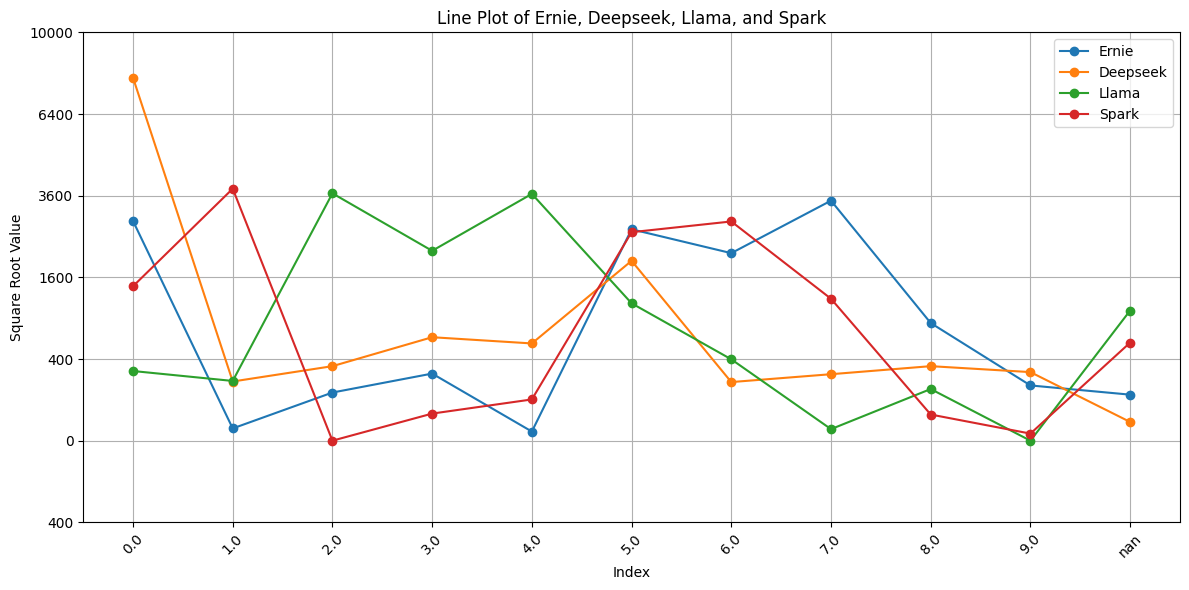

In [25]:
# 绘制折线图
plt.figure(figsize=(12, 6))  # 调整图形大小
for column in df_sqrt_full.columns:
    plt.plot(df_sqrt_full.index, df_sqrt_full[column], label=column, marker='o')

# 设置横坐标
plt.xticks(df_sqrt_full.index, rotation=45)  # 旋转标签
plt.xlabel('Index')
plt.ylabel('Square Root Value')
plt.title('Line Plot of Ernie, Deepseek, Llama, and Spark')
plt.legend()
plt.grid(True)
# 修改 y 轴刻度标签
# 获取当前 y 轴刻度位置
current_yticks_full = plt.yticks()[0]

# 将刻度位置平方，得到原始数据的值
yticks_labels_full = [int(tick ** 2) for tick in current_yticks_full]  # 刻度标签为整数

# 设置 y 轴刻度标签
plt.yticks(current_yticks_full, yticks_labels_full)

plt.tight_layout()  # 自动调整布局
plt.show()

___

In [26]:
score_minute = scores.copy()
score_minute['发布时间'] = pd.to_datetime(score_minute['发布时间'])
score_minute['time'] = score_minute['发布时间'].dt.time

time_range_1 = (score_minute['time'] >= pd.to_datetime('09:30:00').time()) & \
               (score_minute['time'] <= pd.to_datetime('11:30:00').time())

time_range_2 = (score_minute['time'] >= pd.to_datetime('13:00:00').time()) & \
               (score_minute['time'] <= pd.to_datetime('15:00:00').time())

filtered_score_minute = score_minute[time_range_1 | time_range_2]
filtered_score_minute = filtered_score_minute.drop(columns=['time'])

In [27]:
filtered_score_minute = replace_nan_and_values(filtered_score_minute, 'Ernie')
filtered_score_minute = replace_nan_and_values(filtered_score_minute, 'Deepseek')
filtered_score_minute = replace_nan_and_values(filtered_score_minute, 'Llama')
filtered_score_minute = replace_nan_and_values(filtered_score_minute, 'Spark')

In [28]:
result_Ernie = analyze_column_counts(filtered_score_minute, 'Ernie')
result_Deepseek = analyze_column_counts(filtered_score_minute, 'Deepseek')
result_Llama = analyze_column_counts(filtered_score_minute, 'Llama')
result_Spark = analyze_column_counts(filtered_score_minute, 'Spark')

In [29]:
df_count = pd.DataFrame({'Ernie': result_Ernie, 'Deepseek': result_Deepseek, 'Llama': result_Llama, 'Spark': result_Spark})
df_count = df_count.fillna(0)

In [30]:
df_count.index = df_count.index.astype(str)  # 将索引统一为字符串
df_sqrt = df_count.applymap(sqrt_function)

C:\Users\Pratt\AppData\Local\Temp\ipykernel_34124\1079536547.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sqrt = df_count.applymap(sqrt_function)


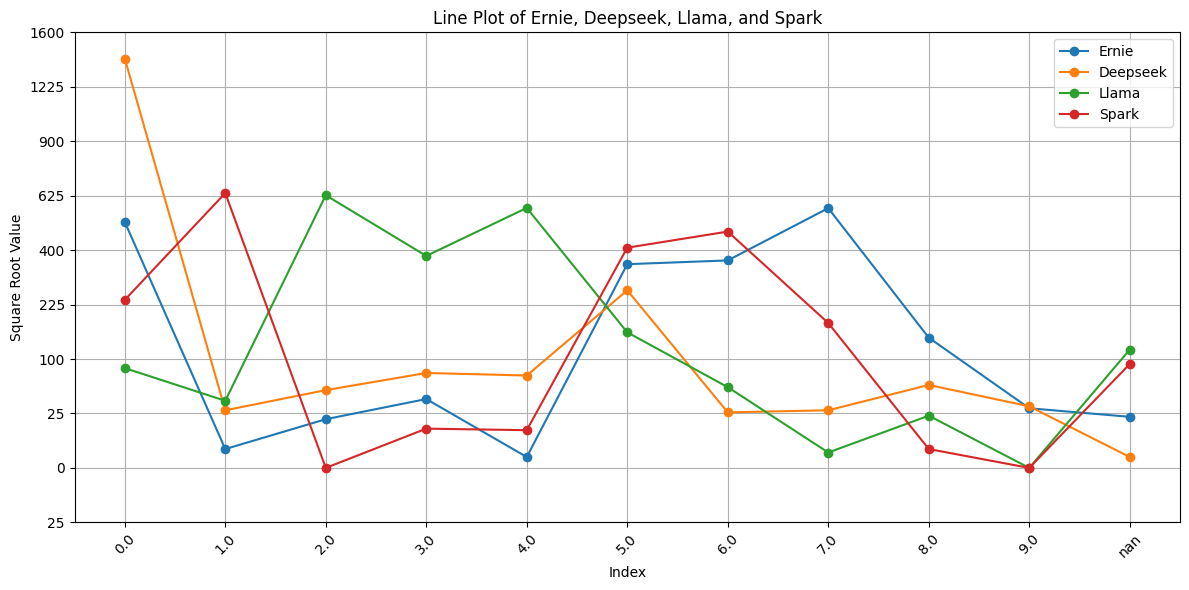

In [31]:
# 绘制折线图
plt.figure(figsize=(12, 6))  # 调整图形大小
for column in df_sqrt.columns:
    plt.plot(df_sqrt.index, df_sqrt[column], label=column, marker='o')

# 设置横坐标
plt.xticks(df_sqrt.index, rotation=45)  # 旋转标签
plt.xlabel('Index')
plt.ylabel('Square Root Value')
plt.title('Line Plot of Ernie, Deepseek, Llama, and Spark')
plt.legend()
plt.grid(True)
# 修改 y 轴刻度标签
# 获取当前 y 轴刻度位置
current_yticks = plt.yticks()[0]

# 将刻度位置平方，得到原始数据的值
yticks_labels = [int(tick ** 2) for tick in current_yticks]  # 刻度标签为整数

# 设置 y 轴刻度标签
plt.yticks(current_yticks, yticks_labels)

plt.tight_layout()  # 自动调整布局
plt.show()

________

In [102]:
# Data on frequency similarity
# compare similarity
from scipy import stats

In [ ]:
def compare_stats(df1, df2):
    stats1 = df1.describe()
    stats2 = df2.describe()
    return stats1.compare(stats2)

def compare_distributions(df1, df2, column):
    # 对数值型列使用K-S检验
    return stats.ks_2samp(df1[column].dropna(), df2[column].dropna())

In [120]:
comaprison_df = compare_stats(df_count_full,df_count)
Ernie_distrubution = compare_distributions(df_count_full,df_count,'Ernie')
Deepseek_distrubution = compare_distributions(df_count_full,df_count,'Deepseek')
Llama_distrubution = compare_distributions(df_count_full,df_count,'Llama')
Spark_distrubution = compare_distributions(df_count_full,df_count,'Spark')

In [121]:
comaprison_df

Ernie                 Deepseek                     Llama  \
             self       other         self        other         self   
mean  1154.727273  186.454545  1154.727273   186.454545  1154.727273   
std   1345.801998  218.987380  2296.645819   412.928653  1394.284698   
min      5.000000    1.000000    21.000000     1.000000          NaN   
25%    133.000000   21.000000   237.500000    28.000000   187.000000   
50%    270.000000   40.000000   333.000000    51.000000   397.000000   
75%   2394.500000  356.500000   604.500000    74.000000  1647.000000   
max   3455.000000  569.000000  7903.000000  1413.000000  3669.000000   

                        Spark              
           other         self       other  
mean  186.454545  1154.727273  186.454545  
std   230.056238  1370.657294  225.621082  
min          NaN          NaN         NaN  
25%    30.500000    42.500000    7.500000  
50%    84.000000   577.000000   91.000000  
75%   267.000000  2018.500000  323.500000  
max   627.000000  3808.000000  637.000000

In [ ]:
df_count_full
df_count

,Ernie,Deepseek,Llama,Spark
0.0,2895,7903,291.0,1430.0
1.0,9,210,214.0,3808.0
2.0,139,333,3669.0,0.0
3.0,270,642,2162.0,44.0
4.0,5,567,3653.0,102.0
5.0,2680,1940,1132.0,2607.0
6.0,2109,206,397.0,2882.0
7.0,3455,265,8.0,1208.0
8.0,830,333,160.0,41.0
9.0,183,282,0.0,3.0


_____

______

# Loading of the price data and sub function

In [32]:
# 指定.gz文件的路径
gz_file_path_1 = '.\\2024\\1m_price2024-12-21_2024-12-27_1.csv.gz'
gz_file_path_2 = '.\\2024\\1m_price2024-12-21_2024-12-27_2.csv.gz'
gz_file_path_3 = '.\\2024\\1m_price2024-12-21_2024-12-27_3.csv.gz'
gz_file_path_4 = '.\\2024\\1m_price2024-12-14_2024-12-20_1.csv.gz'
gz_file_path_5 = '.\\2024\\1m_price2024-12-14_2024-12-20_2.csv.gz'
gz_file_path_6 = '.\\2024\\1m_price2024-12-14_2024-12-20_3.csv.gz'
gz_file_path_7 = '.\\2024\\1m_price2024-12-07_2024-12-13_1.csv.gz'
gz_file_path_8 = '.\\2024\\1m_price2024-12-07_2024-12-13_2.csv.gz'
gz_file_path_9 = '.\\2024\\1m_price2024-12-07_2024-12-13_3.csv.gz'
gz_file_path_10 = '.\\2024\\1m_price2024-12-01_2024-12-06_1.csv.gz'
gz_file_path_11 = '.\\2024\\1m_price2024-12-01_2024-12-06_2.csv.gz'
gz_file_path_12 = '.\\2024\\1m_price2024-12-01_2024-12-06_3.csv.gz'
gz_file_path_13 = '.\\2024\\1m_price2024-11-23_2024-11-29_1.csv.gz'
gz_file_path_14 = '.\\2024\\1m_price2024-11-23_2024-11-29_2.csv.gz'
gz_file_path_15 = '.\\2024\\1m_price2024-11-23_2024-11-29_3.csv.gz'
gz_file_path_16 = '.\\2024\\1m_price2024-11-16_2024-11-22_1.csv.gz'
gz_file_path_17 = '.\\2024\\1m_price2024-11-16_2024-11-22_2.csv.gz'
gz_file_path_18 = '.\\2024\\1m_price2024-11-16_2024-11-22_3.csv.gz'


path_list = [gz_file_path_2, gz_file_path_3, gz_file_path_4, gz_file_path_5, gz_file_path_6, gz_file_path_7, gz_file_path_8, gz_file_path_9, gz_file_path_10, gz_file_path_11, gz_file_path_12, gz_file_path_13, gz_file_path_14, gz_file_path_15, gz_file_path_16, gz_file_path_17, gz_file_path_18]

In [33]:
merged_df_price = pd.read_csv(gz_file_path_1, compression='gzip')
for path in path_list:
    merged_sperate_price = pd.read_csv(path, compression='gzip')
    merged_df_price = pd.concat([merged_df_price, merged_sperate_price])

In [34]:
merged_df_price['adj_close'] = merged_df_price['close'] * merged_df_price['factor']
grouped_price = merged_df_price.groupby('code')

def calculate_return(group):
    group = group.sort_values(by='date')
    group['return'] = (group['adj_close'].shift(-1) / group['adj_close']) - 1
    return group

df_with_returns = grouped_price.apply(calculate_return)

C:\Users\Pratt\AppData\Local\Temp\ipykernel_34124\1115064878.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_with_returns = grouped_price.apply(calculate_return)


In [35]:
df_returns = df_with_returns[['date', 'code', 'return']]
pivot_return_table = df_returns.pivot(index='date', columns='code', values='return')
pivot_return_table = pivot_return_table.fillna(0)
pivot_return_table_with_cost = (pivot_return_table + 1) * 0.99937184 - 1
pivot_return_table = pivot_return_table.iloc[:-480]
pivot_return_table_with_cost = pivot_return_table_with_cost.iloc[:-480]

____

In [36]:
# here we need the pivot return data for daily analysis with and without cost.
merged_df_price_daily = merged_df_price.copy()
# 【pivot_return_table_daily_with】：加入 transaction cost
# 【pivot_return_table_daily_without】: 没有 transaction cost 加入的

In [37]:
# 确保timestamp列是datetime类型
merged_df_price_daily['date'] = pd.to_datetime(merged_df_price_daily['date'])
# 筛选15:00的数据
daily_15_00_data = merged_df_price_daily[
    (merged_df_price_daily['date'].dt.hour == 15) & 
    (merged_df_price_daily['date'].dt.minute == 0)
]

In [38]:
grouped_daily = daily_15_00_data.groupby('code')
daily_returns = grouped_daily.apply(calculate_return)

C:\Users\Pratt\AppData\Local\Temp\ipykernel_34124\1606807592.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_returns = grouped_daily.apply(calculate_return)


In [39]:
daily_returns_base = daily_returns[['date', 'code', 'return']]
pivot_return_table_daily_without = daily_returns_base.pivot(index='date', columns='code', values='return')

In [40]:
# filling procedure
pivot_return_table_daily_without = pivot_return_table_daily_without.fillna(0)
pivot_return_table_daily_with = (pivot_return_table_daily_without + 1) * 0.99937184 - 1
pivot_return_table_daily_without = pivot_return_table_daily_without.iloc[:-2]
pivot_return_table_daily_with = pivot_return_table_daily_with.iloc[:-2]

______

______

# Quantitative analysis code structure minute

In [41]:
# check of the initial data #
filtered_score_minute

,index,关键词,新闻标题,新闻内容,发布时间,文章来源,新闻链接,Ernie,Deepseek,Llama,Spark,是否有后缀
142,40492,600416.SH,双品牌协力、油电并举，上汽奥迪要当“豪华新势力”,这也是上汽奥迪首次以AUDI和四环双品牌同台形式参展，全方位展现上汽奥迪油电并进战略下的创新...,2024-11-18 09:30:51,中国经济网,http://finance.eastmoney.com/a/202411183242123...,7.0,5.0,2.0,6.0,True
143,40493,600131.SH,双品牌协力、油电并举，上汽奥迪要当“豪华新势力”,这也是上汽奥迪首次以AUDI和四环双品牌同台形式参展，全方位展现上汽奥迪油电并进战略下的创新...,2024-11-18 09:30:51,中国经济网,http://finance.eastmoney.com/a/202411183242123...,7.0,8.0,4.0,5.0,True
144,40494,002690.SZ,双品牌协力、油电并举，上汽奥迪要当“豪华新势力”,这也是上汽奥迪首次以AUDI和四环双品牌同台形式参展，全方位展现上汽奥迪油电并进战略下的创新...,2024-11-18 09:30:51,中国经济网,http://finance.eastmoney.com/a/202411183242123...,7.0,0.0,4.0,1.0,True
145,40499,600056.SH,解码中国医药制造企业研发指数：波动中前行，需多维度强化产业竞争力,医药制造产业革新 在中国医药制造领域，一股创新的浪潮正汹涌澎湃，不断拓宽着行业的边界，引领着...,2024-11-18 09:31:30,21世纪经济报道,http://finance.eastmoney.com/a/202411183242484...,5.0,0.0,1.0,5.0,True
146,40500,600763.SH,解码中国医药制造企业研发指数：波动中前行，需多维度强化产业竞争力,坚持中西医并重，促进中医药传承创新发展和高质量“走出去”。,2024-11-18 09:31:30,21世纪经济报道,http://finance.eastmoney.com/a/202411183242484...,7.0,2.0,NaN,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
12375,116663,603858.SH,陕西步长入选陕西百强企业和民营50强企业榜单,陕西步长制药有限公司（简称“陕西步长”）凭借出色的经营业绩和稳健的发展态势，成功入选榜单。 ...,2024-12-25 14:47:54,中证网,http://finance.eastmoney.com/a/202412253278839...,8.0,5.0,3.0,7.0,True
12376,116666,300765.SZ,消费ETF（159928）交投活跃，新诺威涨近2%，机构：当前食品饮料板块估值仍具性价比,成分股中，新诺威涨1.94%，养元饮品涨0.88%，双汇发展涨0.77%，圣农发展、东鹏饮料...,2024-12-25 14:49:09,21世纪经济报道,http://stock.eastmoney.com/a/20241225327884104...,5.0,0.0,2.0,1.0,True
12377,116667,603156.SH,消费ETF（159928）交投活跃，新诺威涨近2%，机构：当前食品饮料板块估值仍具性价比,成分股中，新诺威涨1.94%，养元饮品涨0.88%，双汇发展涨0.77%，圣农发展、东鹏饮料...,2024-12-25 14:49:09,21世纪经济报道,http://stock.eastmoney.com/a/20241225327884104...,5.0,0.0,2.0,5.0,True
12378,116668,002299.SZ,消费ETF（159928）交投活跃，新诺威涨近2%，机构：当前食品饮料板块估值仍具性价比,成分股中，新诺威涨1.94%，养元饮品涨0.88%，双汇发展涨0.77%，圣农发展、东鹏饮料...,2024-12-25 14:49:09,21世纪经济报道,http://stock.eastmoney.com/a/20241225327884104...,5.0,0.0,0.0,5.0,True


In [42]:
def generate_score_matrix(df,row_name):
    # 将发布时间从字符串转换为datetime对象
    df['发布时间'] = pd.to_datetime(df['发布时间'])
    # 将时间统一为后续时间（例如 9:30:51 变为 9:31:00）
    df['发布时间'] = df['发布时间'].apply(lambda x: x.replace(second=0) + timedelta(minutes=1))
    unique_keywords = df['关键词'].unique()
    unique_times = df['发布时间'].unique()
    matrix = pd.DataFrame(0, index=unique_times, columns=unique_keywords)
    for index, row in df.iterrows():
        if not pd.isna(row[row_name]):  # 忽略NaN
            if row[row_name] >= 5:
                matrix.at[row['发布时间'], row['关键词']] += row[row_name]
    matrix = matrix.fillna(0)
    return matrix

def expand_matrix_to_pivot_table(matrix, pivot_return_table):
    # 创建一个新的 DataFrame，索引和列与 pivot_return_table 相同，并初始化为 0
    expanded_matrix = pd.DataFrame(
        0,  # 初始值为 0
        index=pivot_return_table.index,  # 行索引与 pivot_return_table 相同
        columns=pivot_return_table.columns  # 列索引与 pivot_return_table 相同
    )
    # 将 matrix 中的值填充到 expanded_matrix 中
    expanded_matrix.update(matrix)
    return expanded_matrix

def calculate_weights(df):
    df['总分'] = df.sum(axis=1)
    df_weight = df.iloc[:, :-1].div(df['总分'], axis=0).fillna(0)
    return df_weight

In [43]:
Ernie_score_pivot_minute = generate_score_matrix(filtered_score_minute,'Ernie')
Deepseek_score_pivot_minute = generate_score_matrix(filtered_score_minute,'Deepseek')
Llama_score_pivot_minute = generate_score_matrix(filtered_score_minute,'Llama')
Spark_score_pivot_minute = generate_score_matrix(filtered_score_minute,'Spark')

In [44]:
expanded_Ernie_score_pivot_minute = expand_matrix_to_pivot_table(Ernie_score_pivot_minute, pivot_return_table)
expanded_Deepseek_score_pivot_minute = expand_matrix_to_pivot_table(Deepseek_score_pivot_minute, pivot_return_table)
expanded_Llama_score_pivot_minute = expand_matrix_to_pivot_table(Llama_score_pivot_minute, pivot_return_table)
expanded_Spark_score_pivot_minute = expand_matrix_to_pivot_table(Spark_score_pivot_minute, pivot_return_table)

In [45]:
Ernie_score_pivot_minute_weight = calculate_weights(expanded_Ernie_score_pivot_minute)
Deepseek_score_pivot_minute_weight = calculate_weights(expanded_Deepseek_score_pivot_minute)
Llama_score_pivot_minute_weight = calculate_weights(expanded_Llama_score_pivot_minute)
Spark_score_pivot_minute_weight = calculate_weights(expanded_Spark_score_pivot_minute)

____

in this section we will derive the return of benchmark for minute level

In [46]:
CSI500_index = pd.read_csv('.\\中证500\\中证500.csv')
CSI500_index['trade_time'] = pd.to_datetime(CSI500_index['trade_time'])

# 定义起始和结束日期
start_date = '2024-11-18'
end_date = '2024-12-27'

# 使用布尔索引筛选出指定日期范围内的行
filtered_CSI500 = CSI500_index[(CSI500_index['trade_time'] >= start_date) & (CSI500_index['trade_time'] <= end_date)]

In [47]:
filtered_CSI500['return_1'] = (filtered_CSI500['close'].shift(-1) / filtered_CSI500['close']) - 1
filtered_CSI500['return_2'] = 0.99937184*((filtered_CSI500['close'].shift(-1) / filtered_CSI500['close'])) - 1
filtered_CSI500 = filtered_CSI500.iloc[:-240]

C:\Users\Pratt\AppData\Local\Temp\ipykernel_34124\3830031297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_CSI500['return_1'] = (filtered_CSI500['close'].shift(-1) / filtered_CSI500['close']) - 1
C:\Users\Pratt\AppData\Local\Temp\ipykernel_34124\3830031297.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_CSI500['return_2'] = 0.99937184*((filtered_CSI500['close'].shift(-1) / filtered_CSI500['close'])) - 1


In [48]:
benchmark_index_without = pd.Series(list(filtered_CSI500['return_1']))
benchmark_index_with = pd.Series(list(filtered_CSI500['return_2']))

____

in this section we will use an overall benchmark to check the stock selection performance without cost first

In [49]:
def calculate_total_returns(weights_dfs, returns_df):
    total_returns = pd.DataFrame()
    for name, weights_df in weights_dfs.items():
        # 获取权重名称的第一个单词作为列名
        short_name = name.split('_')[0] 
        total_return = (weights_df * returns_df).sum(axis=1)
        total_returns[short_name] = total_return  # 对每行的加权收益求和
    return total_returns

In [50]:
# 将权重DataFrame放入列表
weights_dfs = {
    "Ernie_score_pivot_minute_weight":Ernie_score_pivot_minute_weight,         "Deepseek_score_pivot_minute_weight":Deepseek_score_pivot_minute_weight, 
    "Llama_score_pivot_minute_weight":Llama_score_pivot_minute_weight, 
    "Spark_score_pivot_minute_weight":Spark_score_pivot_minute_weight}

In [51]:
total_returns_four_without = calculate_total_returns(weights_dfs, pivot_return_table)
total_returns_four_with = calculate_total_returns(weights_dfs, pivot_return_table_with_cost)

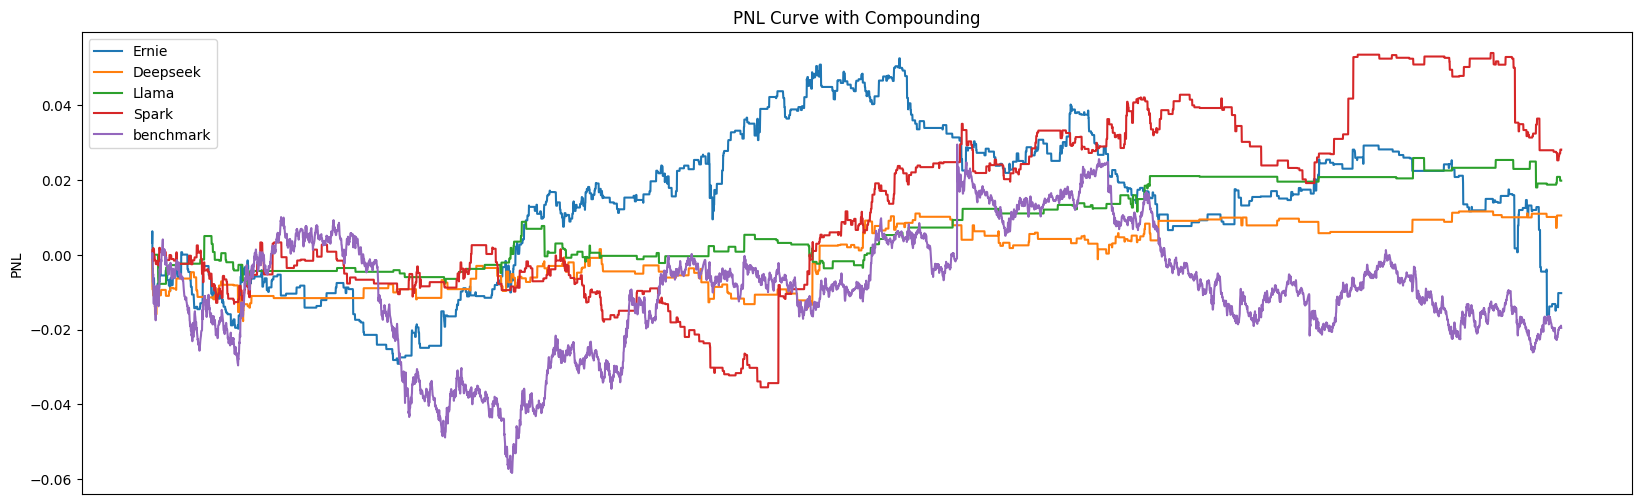

In [52]:
# 使用for循环计算复利并绘制PNL曲线(without cost)
plt.figure(figsize=(20, 6))

for column in total_returns_four_without.columns:  # 遍历每一列
    pnl = (1 + total_returns_four_without[column]).cumprod() - 1  # 计算复利
    plt.plot(pnl, label=column)  # 绘制PNL曲线

benchmark_pnl = (1 + benchmark_index_without.values).cumprod() - 1
benchmark_pnl = pd.Series(benchmark_pnl, index=total_returns_four_without.index)
plt.plot(benchmark_pnl, label='benchmark')
# 不显示x坐标
plt.xticks([])

# 添加标签和图例
plt.ylabel('PNL')
plt.title('PNL Curve with Compounding')
plt.legend()

# 显示图形
plt.show()

_____

in this section we will test the seperate benchmark with corresponding trading frequency with cost

In [53]:
bench_weight_df = pd.DataFrame()
for key, df in weights_dfs.items():
    short_name = key.split('_')[0]
    bench_weight_df[short_name] = (df != 0).any(axis=1).astype(int)

In [54]:
# 初始化一个空的 DataFrame 用于存储结果
strategy_returns_with_benchmark = pd.DataFrame()
cumulative_returns = pd.DataFrame()
for col in bench_weight_df.columns:
    strategy_return = total_returns_four_with[col]
    benchmark_return = bench_weight_df[col] * benchmark_index_with.values
    strategy_returns_with_benchmark[f'{col}_strategy'] = strategy_return
    strategy_returns_with_benchmark[f'{col}_benchmark'] = benchmark_return

for col in strategy_returns_with_benchmark.columns:
    cumulative_returns[col] = (1 + strategy_returns_with_benchmark[col]).cumprod() - 1

In [55]:
def plot_pnl(strategy_name, cumulative_returns):
    plt.figure(figsize=(20, 6))
    plt.plot(cumulative_returns[f'{strategy_name}_strategy'], label=f'{strategy_name} Strategy', color='blue', linewidth=2)
    plt.plot(cumulative_returns[f'{strategy_name}_benchmark'], label=f'{strategy_name} Benchmark', color='orange', linewidth=2)
    plt.title(f'{strategy_name} PnL', fontsize=16)
    plt.ylabel('Cumulative Return', fontsize=14)
    plt.legend()
    plt.xticks([])
    plt.show()

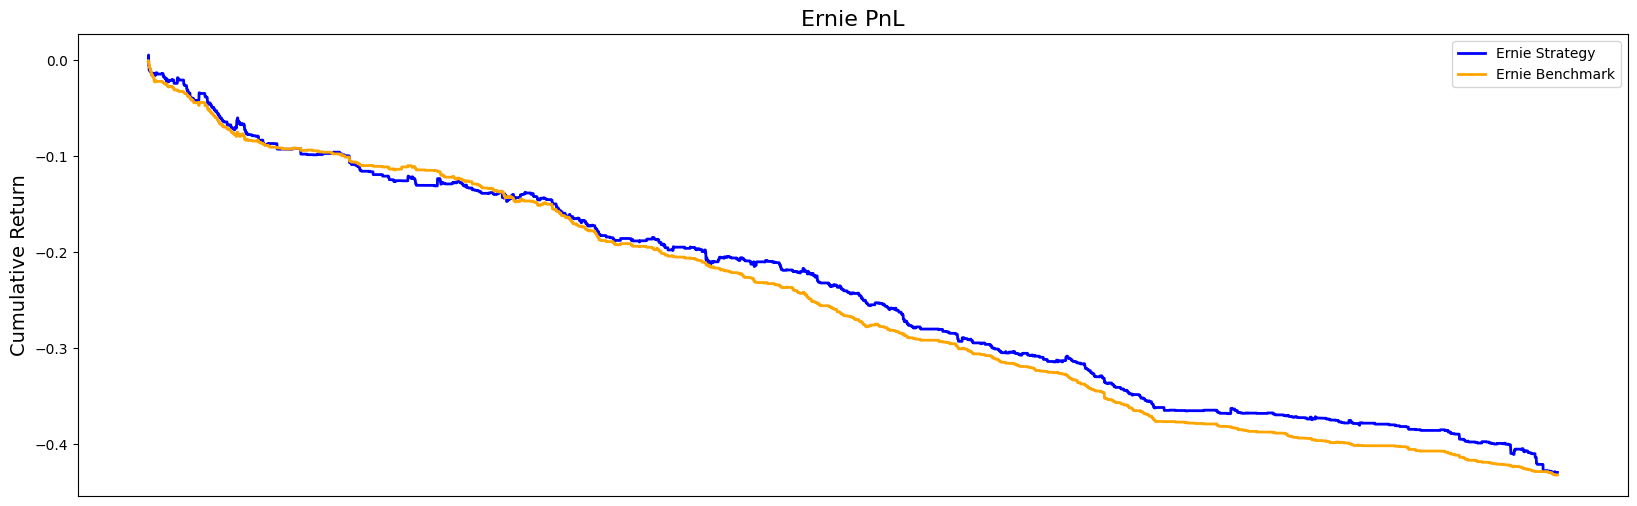

In [56]:
# 分别调用四次，绘制每个策略的 PnL 图
plot_pnl('Ernie', cumulative_returns)

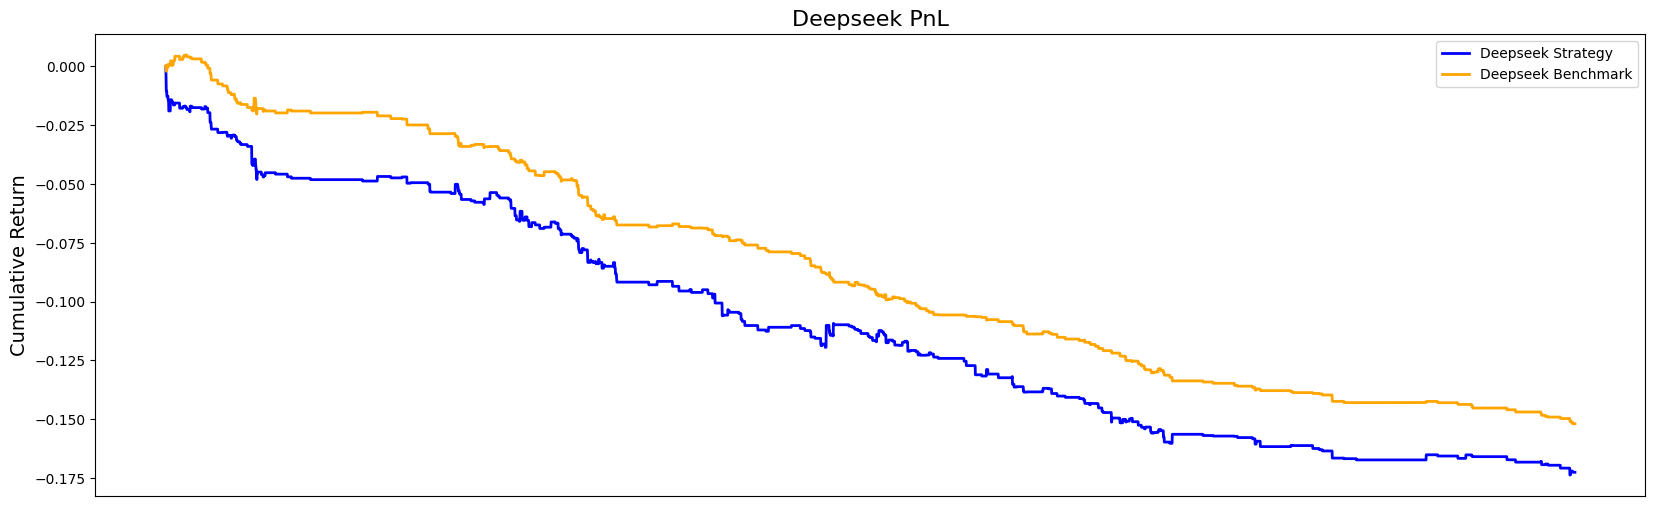

In [57]:
plot_pnl('Deepseek', cumulative_returns)

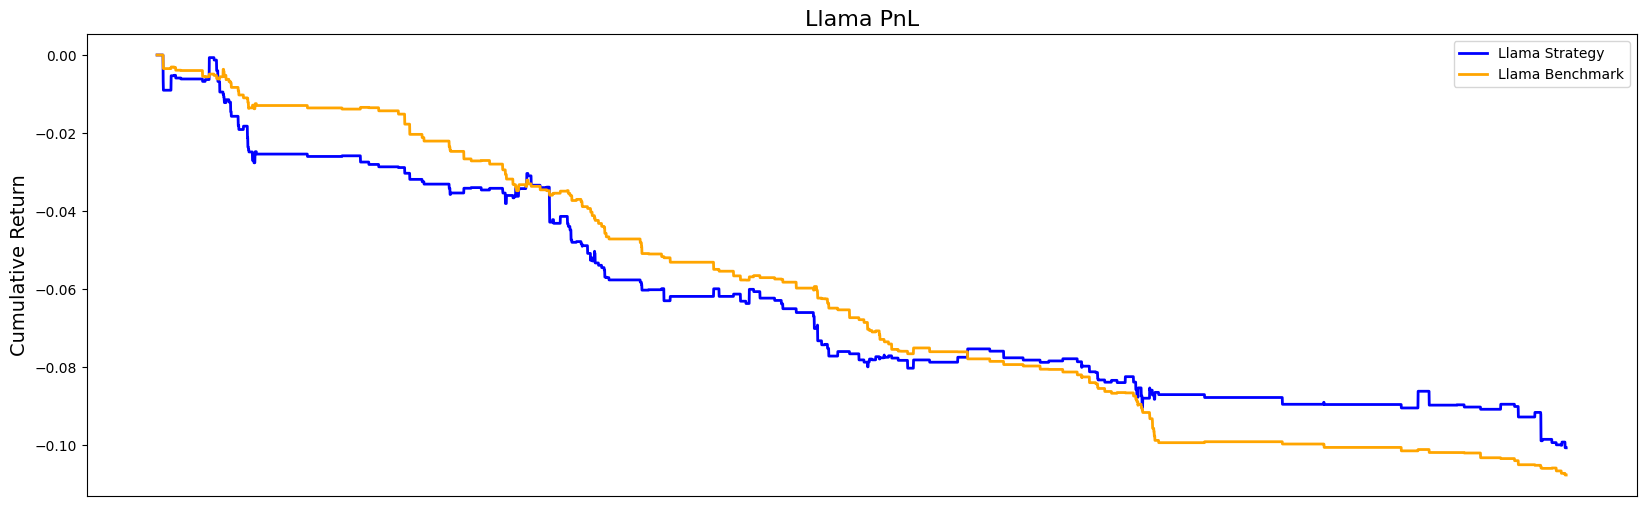

In [58]:
plot_pnl('Llama', cumulative_returns)

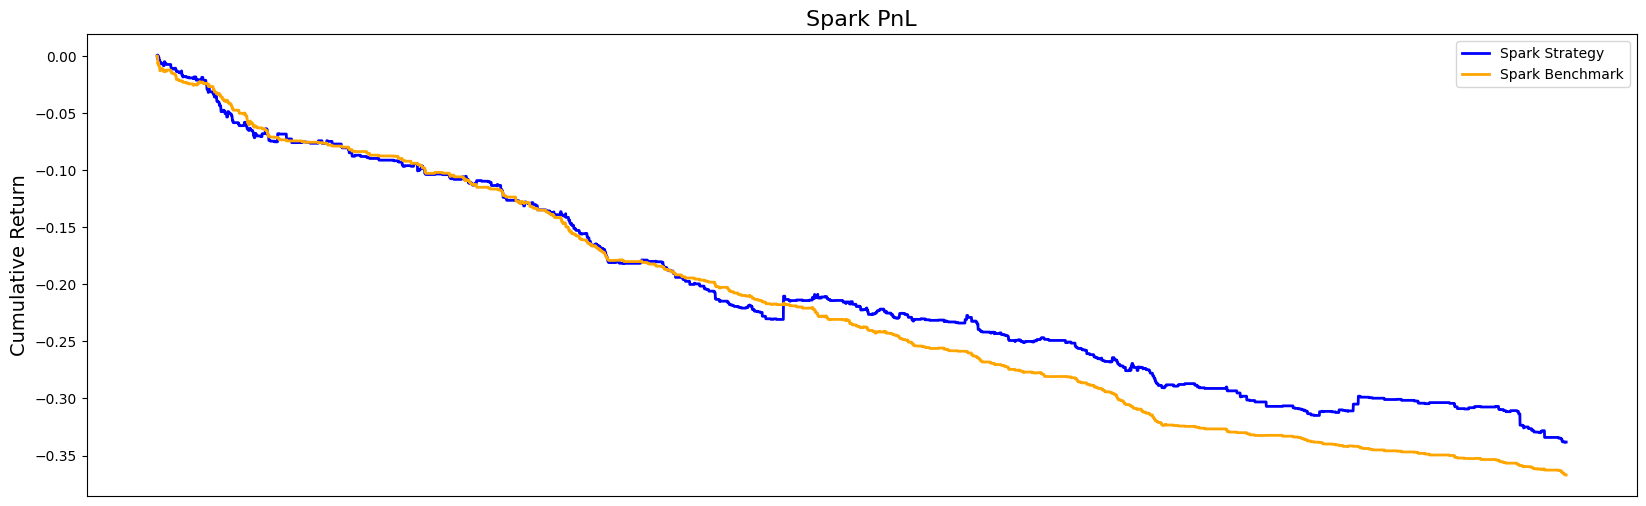

In [59]:
plot_pnl('Spark', cumulative_returns)

In [60]:
# data analysis in each ratio.
# 定义计算最大回撤的函数
def calculate_max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

# 定义计算夏普比率的函数
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    return excess_returns.mean() / excess_returns.std() * np.sqrt(252*240)  # 年化夏普比率

# 定义计算胜率的函数
def calculate_win_rate(strategy_returns, benchmark_returns):
    valid_mask = strategy_returns != 0
    valid_strategy_returns = strategy_returns[valid_mask]
    valid_benchmark_returns = benchmark_returns[valid_mask]
    win_rate = (valid_strategy_returns > valid_benchmark_returns).mean()
    return win_rate

# 定义计算年化收益率的函数
def calculate_annualized_yield(returns):
    cumulative_return = (1 + returns).prod() - 1
    return (1 + cumulative_return) ** (252*240 / len(returns)) - 1  # 年化收益率

# 定义计算波动率的函数
def calculate_volatility(returns):
    return returns.std()

In [61]:
metrics_table = pd.DataFrame()
# 遍历每个策略，计算指标
for col in ['Ernie', 'Deepseek', 'Llama', 'Spark']:
    strategy_returns = cumulative_returns[f'{col}_strategy'].diff().dropna()  # 计算每日收益率
    benchmark_returns = cumulative_returns[f'{col}_benchmark'].diff().dropna()  # 计算基准每日收益率
    
    metrics = {
        'Max Drawdown': calculate_max_drawdown(strategy_returns),
        'Sharpe Ratio': calculate_sharpe_ratio(strategy_returns),
        'Win Rate': calculate_win_rate(strategy_returns, benchmark_returns),
        'Annualized Yield': calculate_annualized_yield(strategy_returns),
        'Volatility': calculate_volatility(strategy_returns)
    }
    metrics_table[col] = pd.Series(metrics)

In [62]:
# 打印指标分析表格
print(metrics_table)

                      Ernie   Deepseek      Llama      Spark
Max Drawdown      -0.354103  -0.155250  -0.096008  -0.288469
Sharpe Ratio     -28.265395 -16.925856 -12.704719 -22.366432
Win Rate           0.488027   0.500000   0.575000   0.509272
Annualized Yield  -0.979805  -0.789295  -0.596891  -0.952806
Volatility         0.000560   0.000373   0.000290   0.000553


____

in this section we will test the seperate benchmark with corresponding trading frequency without cost

In [63]:
# 初始化一个空的 DataFrame 用于存储结果
strategy_returns_with_benchmark_without = pd.DataFrame()
cumulative_returns_without = pd.DataFrame()
for col in bench_weight_df.columns:
    strategy_return_without = total_returns_four_without[col]
    benchmark_return_without = bench_weight_df[col] * benchmark_index_without.values
    strategy_returns_with_benchmark_without[f'{col}_strategy'] = strategy_return_without
    strategy_returns_with_benchmark_without[f'{col}_benchmark'] = benchmark_return_without

for col in strategy_returns_with_benchmark_without.columns:
    cumulative_returns_without[col] = (1 + strategy_returns_with_benchmark_without[col]).cumprod() - 1

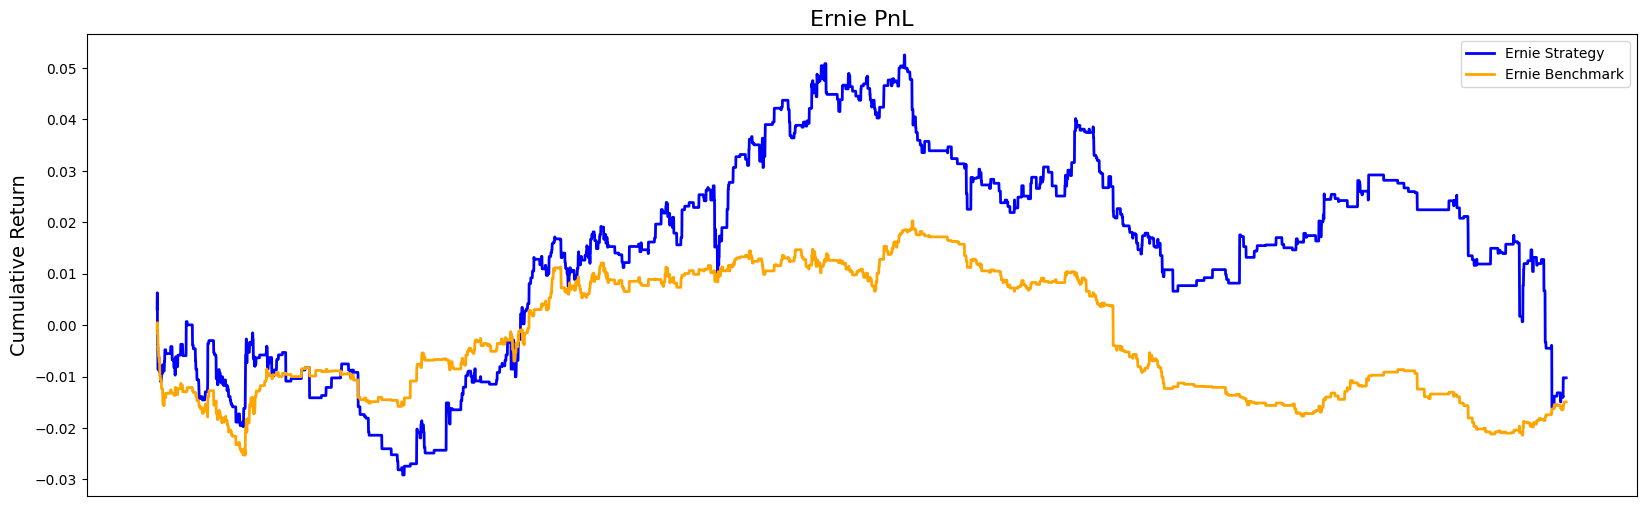

In [64]:
# 分别调用四次，绘制每个策略的 PnL 图
plot_pnl('Ernie', cumulative_returns_without)

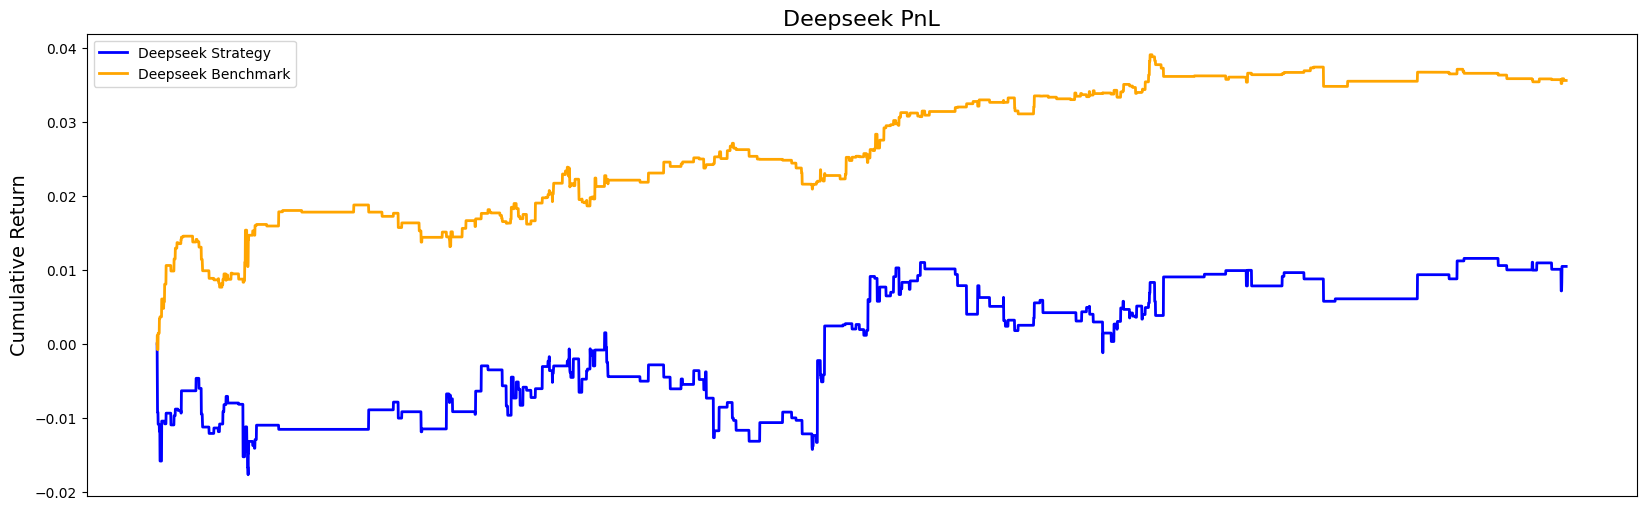

In [65]:
plot_pnl('Deepseek', cumulative_returns_without)

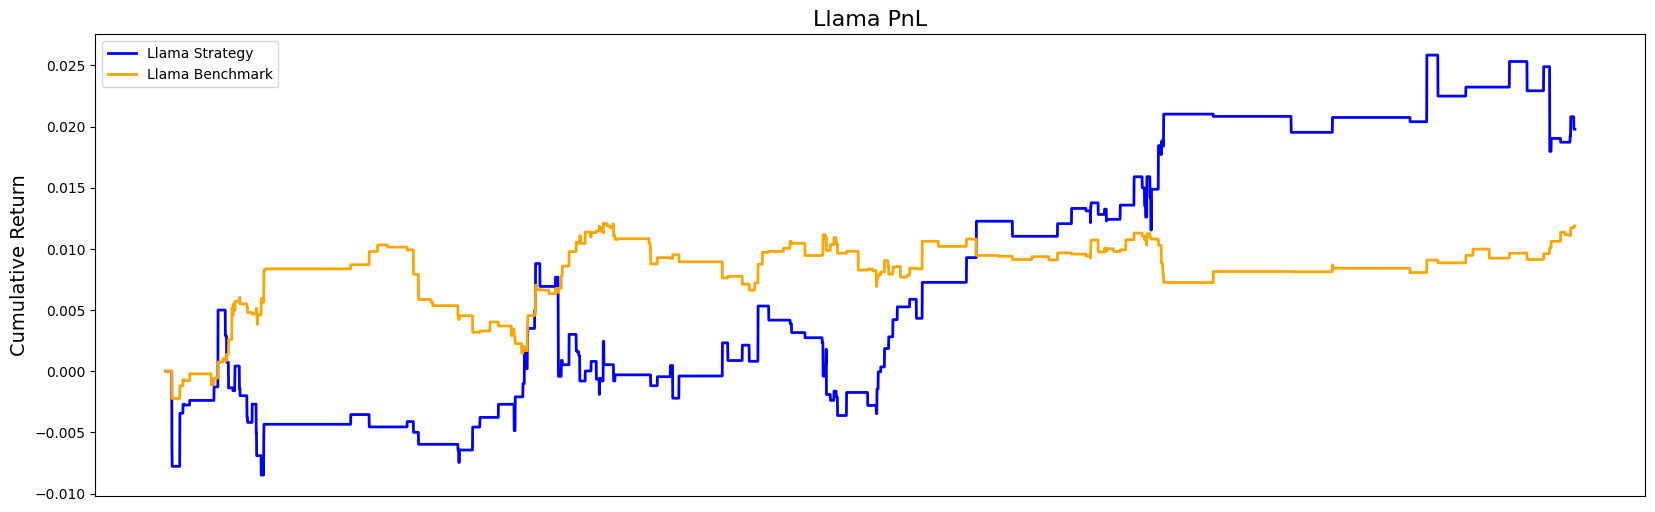

In [66]:
plot_pnl('Llama', cumulative_returns_without)

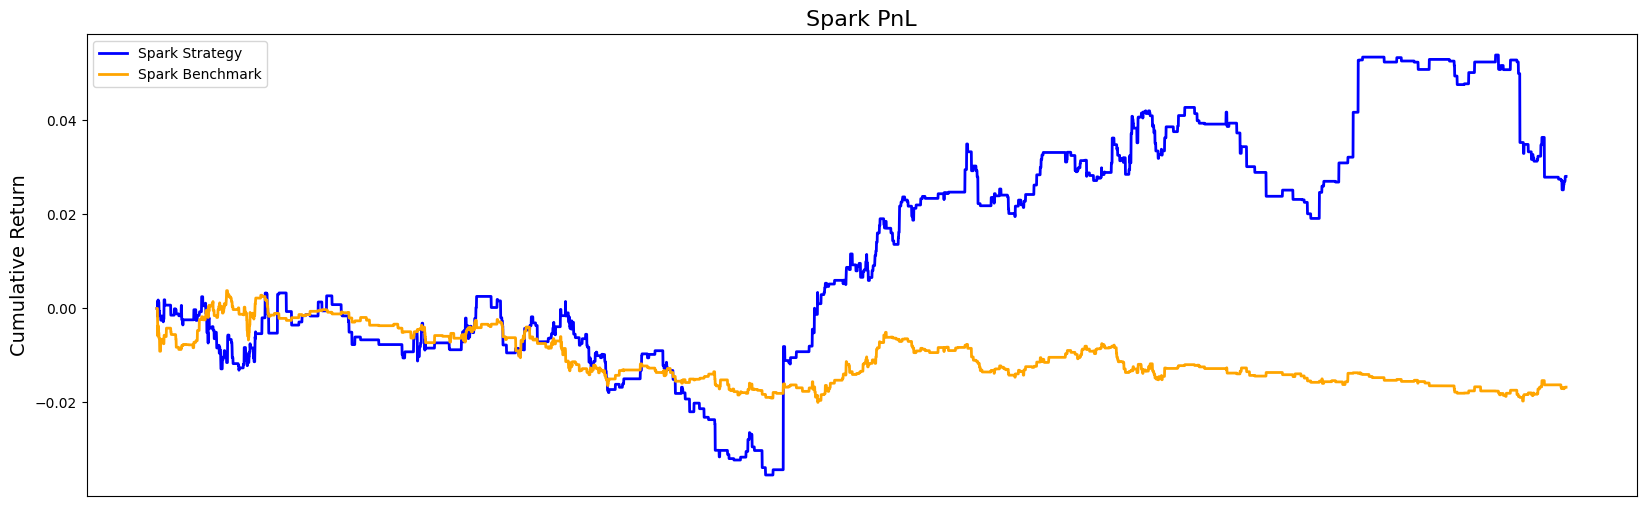

In [67]:
plot_pnl('Spark', cumulative_returns_without)

In [68]:
metrics_table_without = pd.DataFrame()
# 遍历每个策略，计算指标
for col in ['Ernie', 'Deepseek', 'Llama', 'Spark']:
    strategy_returns_without = cumulative_returns_without[f'{col}_strategy'].diff().dropna()  # 计算每日收益率
    benchmark_returns_without = cumulative_returns_without[f'{col}_benchmark'].diff().dropna()  # 计算基准每日收益率
    
    metrics_without = {
        'Max Drawdown': calculate_max_drawdown(strategy_returns_without),
        'Sharpe Ratio': calculate_sharpe_ratio(strategy_returns_without),
        'Win Rate': calculate_win_rate(strategy_returns_without, benchmark_returns_without),
        'Annualized Yield': calculate_annualized_yield(strategy_returns_without),
        'Volatility': calculate_volatility(strategy_returns_without)
    }
    metrics_table_without[col] = pd.Series(metrics_without)

In [69]:
# 打印指标分析表格
print(metrics_table_without)

                     Ernie  Deepseek     Llama     Spark
Max Drawdown     -0.066881 -0.015732 -0.013420 -0.038275
Sharpe Ratio     -0.715896  0.989290  2.458387  1.532648
Win Rate          0.478006  0.472103  0.579310  0.493308
Annualized Yield -0.126180  0.093955  0.191751  0.270342
Volatility        0.000685  0.000388  0.000294  0.000671


______

______

# Quantitative analysis code structure daily

In [70]:
#initialate daily data
scores

,index,关键词,新闻标题,新闻内容,发布时间,文章来源,新闻链接,Ernie,Deepseek,Llama,Spark,是否有后缀
0,39936,600816.SH,维信金科CTO史红哲：以场景探索驱动维信大模型应用发展,从维信金科的实践来看，其合作机构多是地方中小银行，在提升客户服务体验和效率、增强获客能力、强...,2024-11-18 00:14:34,21世纪经济报道,http://finance.eastmoney.com/a/202411183241837...,5.0,3.0,2.0,5.0,True
1,39937,002373.SZ,维信金科CTO史红哲：以场景探索驱动维信大模型应用发展,据介绍，为此，维信金科研发了昆仑镜智能风控系统，该系统通过智能风险识别，基于征信大数据等标准...,2024-11-18 00:14:34,21世纪经济报道,http://finance.eastmoney.com/a/202411183241837...,5.0,0.0,4.0,5.0,True
2,39938,688387.SH,维信金科CTO史红哲：以场景探索驱动维信大模型应用发展,从维信金科的实践来看，其合作机构多是地方中小银行，在提升客户服务体验和效率、增强获客能力、强...,2024-11-18 00:14:34,21世纪经济报道,http://finance.eastmoney.com/a/202411183241837...,5.0,0.0,2.0,5.0,True
3,39942,603056.SH,高德红外多项硬核装备亮相2024珠海航展,同时，GAM系列反坦克DD还列入中央军委装备发展部军贸装备谱系产品进行展示，彰显高德红外在国...,2024-11-18 00:30:57,每日经济新闻,http://finance.eastmoney.com/a/202411183241838...,5.0,0.0,0.0,7.0,True
4,39944,002414.SZ,高德红外多项硬核装备亮相2024珠海航展,同时，GAM系列反坦克DD还列入中央军委装备发展部军贸装备谱系产品进行展示，彰显高德红外在国...,2024-11-18 00:30:57,每日经济新闻,http://finance.eastmoney.com/a/202411183241838...,5.0,0.0,2.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...
12697,118141,300285.SZ,山东矿机：公司生产经营活动一切正常,山东矿机（002526.SZ）12月25日在投资者互动平台表示，您好，公司生产经营活动一切正...,2024-12-25 23:11:36,每日经济新闻,http://finance.eastmoney.com/a/202412253279157...,5.0,5.0,2.0,1.0,True
12698,118142,600350.SH,山东矿机：公司生产经营活动一切正常,山东矿机（002526.SZ）12月25日在投资者互动平台表示，您好，公司生产经营活动一切正...,2024-12-25 23:11:36,每日经济新闻,http://finance.eastmoney.com/a/202412253279157...,7.0,0.0,2.0,NaN,True
12699,118143,688234.SH,山东矿机：公司生产经营活动一切正常,山东矿机（002526.SZ）12月25日在投资者互动平台表示，您好，公司生产经营活动一切正...,2024-12-25 23:11:36,每日经济新闻,http://finance.eastmoney.com/a/202412253279157...,5.0,4.0,3.0,6.0,True
12700,118145,601615.SH,熵基科技：公司的AI数字标牌主要应用在智慧零售场景,公司的AI数字标牌主要应用在智慧零售场景。公司将持续保持对国内外最新先进技术的关注，坚持自主...,2024-12-25 23:11:40,每日经济新闻,http://finance.eastmoney.com/a/202412253279158...,6.0,3.0,3.0,1.0,True


In [71]:
def generate_score_matrix_daily(df, row_name):
    # 将发布时间从字符串转换为datetime对象
    df['发布时间'] = pd.to_datetime(df['发布时间'])
    
    # 调整时间逻辑：15:00之前算当日，15:00之后算下一日
    def adjust_date(dt):
        if dt.time() >= pd.to_datetime('15:00:00').time():
            return dt.replace(hour=15, minute=0, second=0) + pd.Timedelta(days=1)
        else:
            return dt.replace(hour=15, minute=0, second=0)
    
    df['adjusted_date'] = df['发布时间'].apply(adjust_date)
    
    unique_keywords = df['关键词'].unique()
    unique_dates = df['adjusted_date'].unique()
    matrix = pd.DataFrame(0, index=unique_dates, columns=unique_keywords)
    
    for index, row in df.iterrows():
        if not pd.isna(row[row_name]):  # 忽略NaN
            if row[row_name] >= 5:
                matrix.at[row['adjusted_date'], row['关键词']] += row[row_name]
    
    matrix = matrix.fillna(0)
    return matrix

def expand_matrix_to_pivot_table_daily(matrix, pivot_return_table):
    # 创建一个新的 DataFrame，索引和列与 pivot_return_table 相同，并初始化为 0
    expanded_matrix = pd.DataFrame(
        0,  # 初始值为 0
        index=pivot_return_table.index,  # 行索引与 pivot_return_table 相同
        columns=pivot_return_table.columns  # 列索引与 pivot_return_table 相同
    )
    # 将 matrix 中的值填充到 expanded_matrix 中
    expanded_matrix.update(matrix)
    return expanded_matrix

In [72]:
Ernie_score_pivot_daily = generate_score_matrix_daily(scores,'Ernie')
Deepseek_score_pivot_daily = generate_score_matrix_daily(scores,'Deepseek')
Llama_score_pivot_daily = generate_score_matrix_daily(scores,'Llama')
Spark_score_pivot_daily = generate_score_matrix_daily(scores,'Spark')
Ernie_score_pivot_daily = Ernie_score_pivot_daily.iloc[:-1]
Deepseek_score_pivot_daily = Deepseek_score_pivot_daily.iloc[:-1]
Llama_score_pivot_daily = Llama_score_pivot_daily.iloc[:-1]
Spark_score_pivot_daily = Spark_score_pivot_daily.iloc[:-1]

In [73]:
def process_dataframe(df):
    # 创建副本以避免修改原始DataFrame
    df = df.copy()
    rows_to_process = [5, 11, 17, 23, 29]  # 对应第6,12,18,24,30行
    for row in rows_to_process:
        # 检查行是否存在
        if row < len(df) - 1:
            # 将当前行加到下一行
            df.iloc[row+1] = df.iloc[row] + df.iloc[row+1]
    
    df = df.drop(df.index[rows_to_process])
    return df

In [74]:
Ernie_score_pivot_daily = process_dataframe(Ernie_score_pivot_daily)
Deepseek_score_pivot_daily = process_dataframe(Deepseek_score_pivot_daily)
Llama_score_pivot_daily = process_dataframe(Llama_score_pivot_daily)
Spark_score_pivot_daily = process_dataframe(Spark_score_pivot_daily)

In [75]:
expanded_Ernie_score_pivot_daily = expand_matrix_to_pivot_table_daily(Ernie_score_pivot_daily, pivot_return_table_daily_with)
expanded_Deepseek_score_pivot_daily = expand_matrix_to_pivot_table_daily(Deepseek_score_pivot_daily, pivot_return_table_daily_with)
expanded_Llama_score_pivot_daily = expand_matrix_to_pivot_table_daily(Llama_score_pivot_daily, pivot_return_table_daily_with)
expanded_Spark_score_pivot_daily = expand_matrix_to_pivot_table_daily(Spark_score_pivot_daily, pivot_return_table_daily_with)

Ernie_score_pivot_daily_weight = calculate_weights(expanded_Ernie_score_pivot_daily)
Deepseek_score_pivot_daily_weight = calculate_weights(expanded_Deepseek_score_pivot_daily)
Llama_score_pivot_daily_weight = calculate_weights(expanded_Llama_score_pivot_daily)
Spark_score_pivot_daily_weight = calculate_weights(expanded_Spark_score_pivot_daily)

____

write down about the daily benchmark data 

In [76]:
filtered_CSI500_daily = CSI500_index[(CSI500_index['trade_time'] >= start_date) & (CSI500_index['trade_time'] <= end_date)]
filtered_CSI500_daily = filtered_CSI500_daily.groupby(filtered_CSI500_daily["trade_time"].dt.date).last()

In [77]:
filtered_CSI500_daily['return_1'] = (filtered_CSI500_daily['close'].shift(-1) / filtered_CSI500_daily['close']) - 1
filtered_CSI500_daily['return_2'] = 0.99937184*((filtered_CSI500_daily['close'].shift(-1) / filtered_CSI500_daily['close'])) - 1
filtered_CSI500_daily = filtered_CSI500_daily.iloc[:-1]

In [78]:
benchmark_index_daily_without = pd.Series(list(filtered_CSI500_daily['return_1']))
benchmark_index_daily_with = pd.Series(list(filtered_CSI500_daily['return_2']))

____

In [79]:
# 将权重DataFrame放入列表
weights_daily_dfs = {
    "Ernie_score_pivot_minute_weight":Ernie_score_pivot_daily_weight,         "Deepseek_score_pivot_minute_weight":Deepseek_score_pivot_daily_weight, 
    "Llama_score_pivot_minute_weight":Llama_score_pivot_daily_weight, 
    "Spark_score_pivot_minute_weight":Spark_score_pivot_daily_weight}

In [80]:
total_returns_four_daily_without = calculate_total_returns(weights_daily_dfs, pivot_return_table_daily_without)
total_returns_four_daily_with = calculate_total_returns(weights_daily_dfs, pivot_return_table_daily_with)

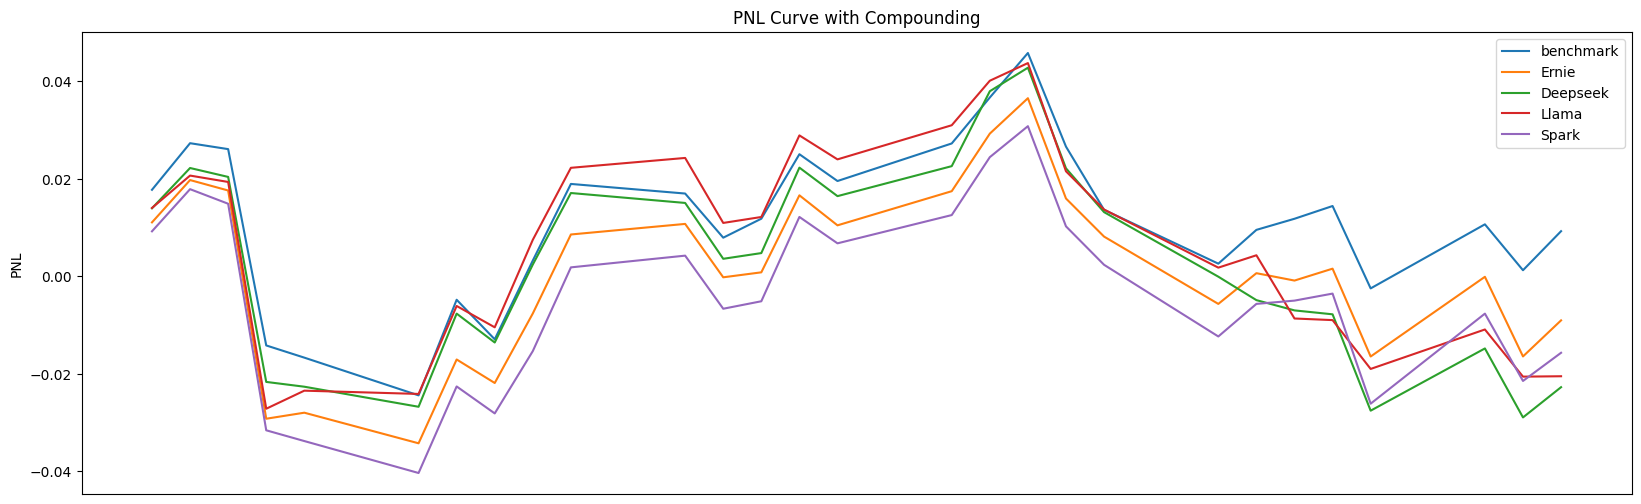

In [81]:
# 使用for循环计算复利并绘制PNL曲线(without cost)
plt.figure(figsize=(20, 6))

# 确保基准数据和策略数据使用相同的索引
common_index = total_returns_four_daily_without.index

benchmark_pnl_daily = (1 + benchmark_index_daily_without.values).cumprod() - 1
benchmark_pnl_daily = pd.Series(benchmark_pnl_daily, index=total_returns_four_daily_without.index)
plt.plot(benchmark_pnl_daily, label='benchmark')

for column in total_returns_four_daily_without.columns:  # 遍历每一列
    pnl = (1 + total_returns_four_daily_without[column]).cumprod() - 1  # 计算复利
    plt.plot(pnl, label=column)  # 绘制PNL曲线

# 不显示x坐标
plt.xticks([])

# 添加标签和图例
plt.ylabel('PNL')
plt.title('PNL Curve with Compounding')
plt.legend()

# 显示图形
plt.show()

In [82]:
bench_weight_df_daily = pd.DataFrame()
for key, df in weights_daily_dfs.items():
    short_name = key.split('_')[0]
    bench_weight_df_daily[short_name] = (df != 0).any(axis=1).astype(int)

In [83]:
# 初始化一个空的 DataFrame 用于存储结果
strategy_returns_daily_with_benchmark = pd.DataFrame()
cumulative_returns_daily = pd.DataFrame()
for col in bench_weight_df_daily.columns:
    strategy_daily_return = total_returns_four_daily_with[col]
    benchmark_daily_return = bench_weight_df_daily[col] * benchmark_index_daily_with.values
    strategy_returns_daily_with_benchmark[f'{col}_strategy'] = strategy_daily_return
    strategy_returns_daily_with_benchmark[f'{col}_benchmark'] = benchmark_daily_return

for col in strategy_returns_daily_with_benchmark.columns:
    cumulative_returns_daily[col] = (1 + strategy_returns_daily_with_benchmark[col]).cumprod() - 1

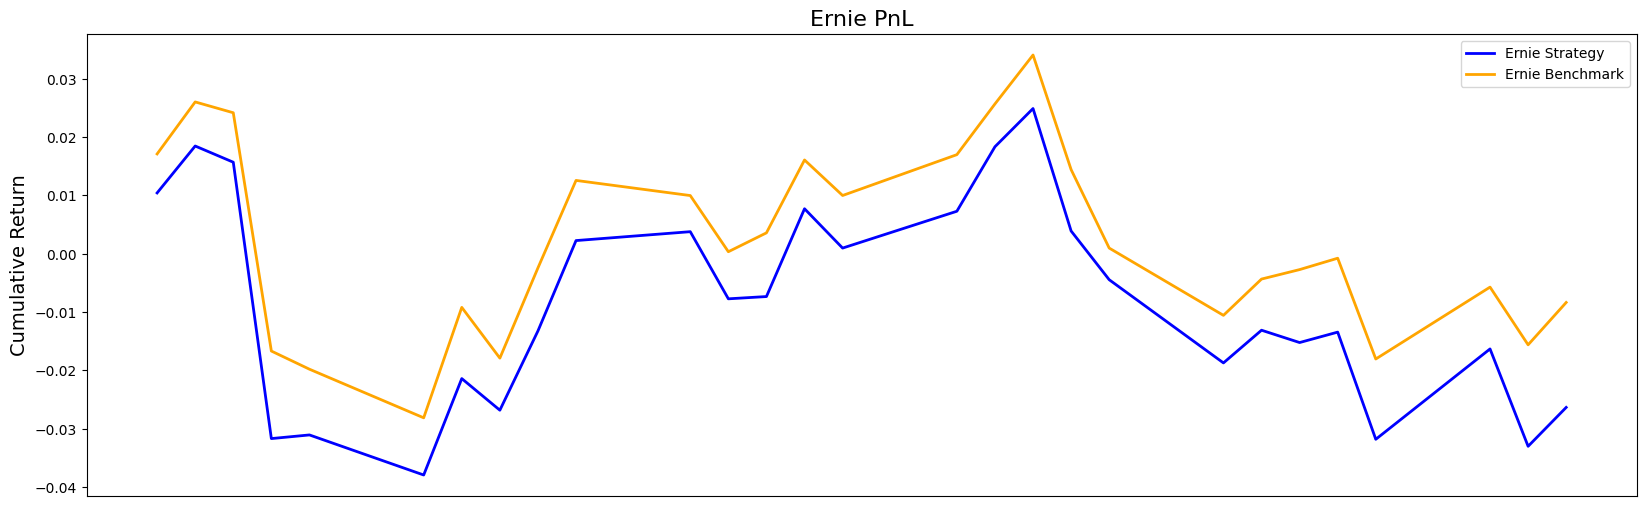

In [84]:
plot_pnl('Ernie', cumulative_returns_daily)

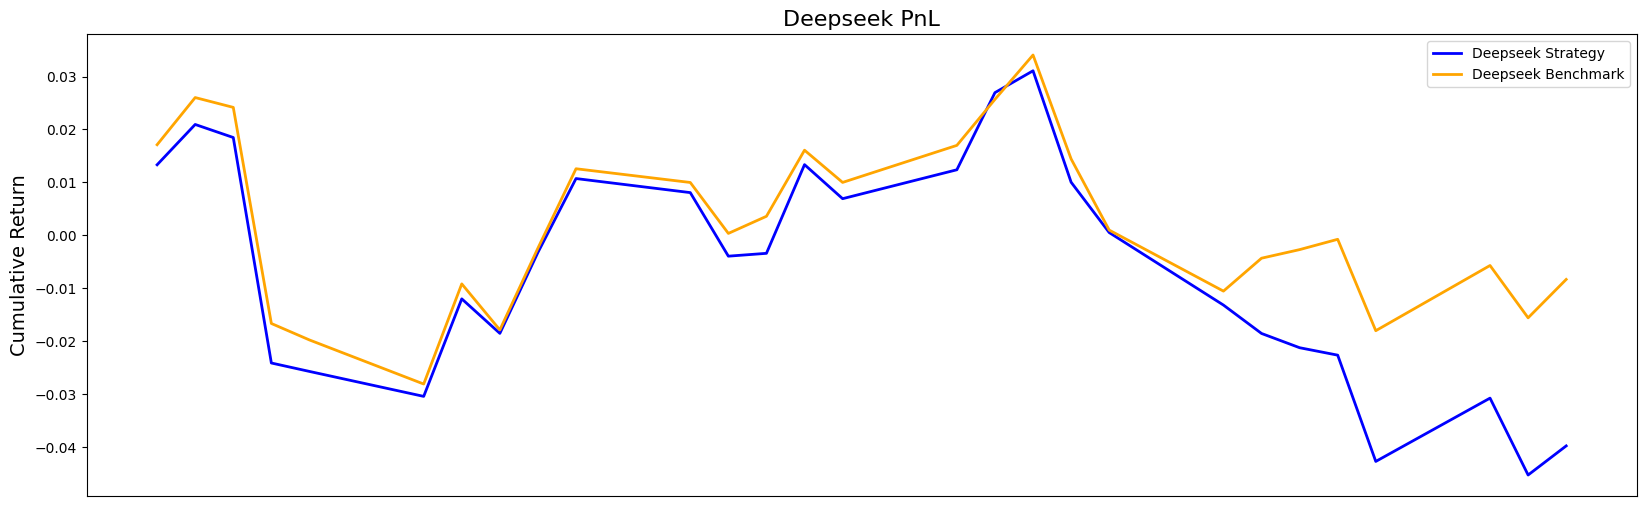

In [85]:
plot_pnl('Deepseek', cumulative_returns_daily)

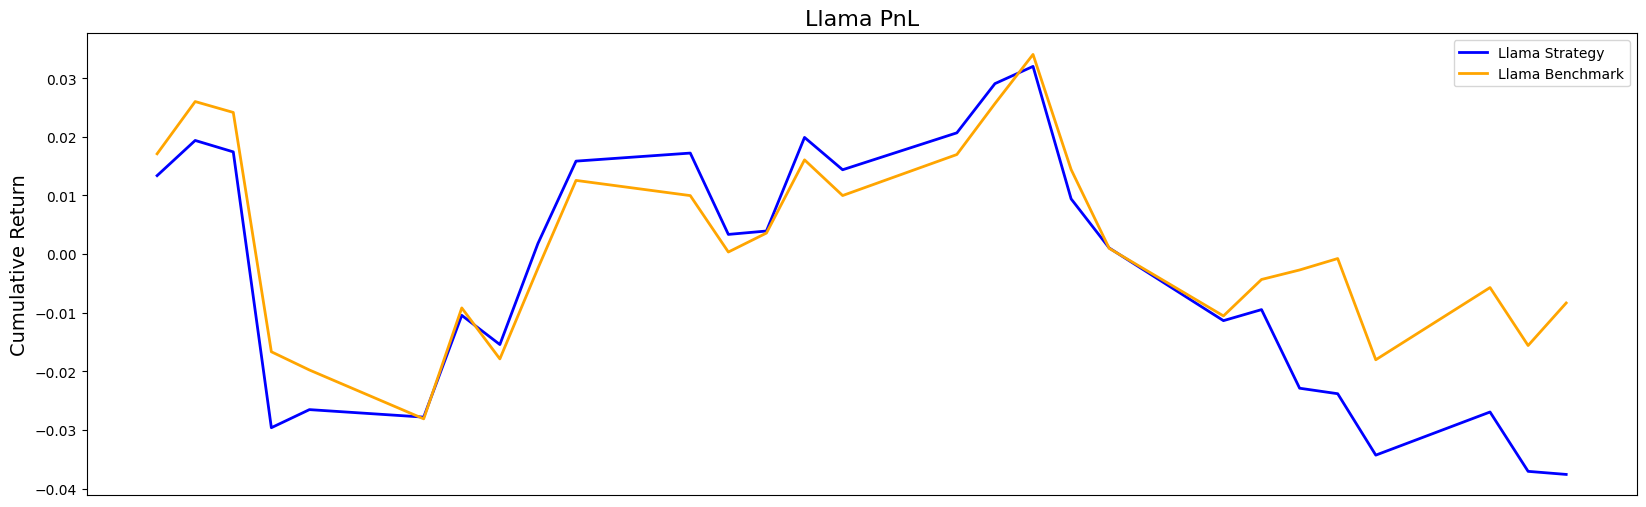

In [86]:
plot_pnl('Llama', cumulative_returns_daily)

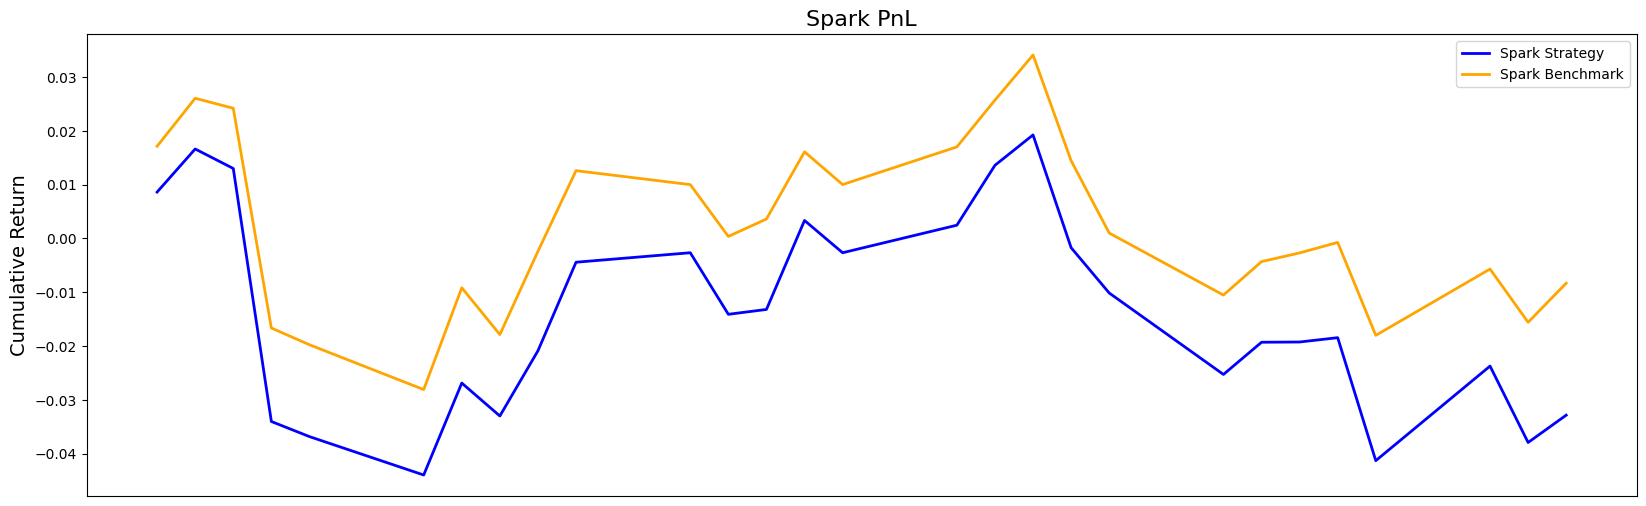

In [87]:
plot_pnl('Spark', cumulative_returns_daily)

In [88]:
# data analysis in each ratio.
# 定义计算最大回撤的函数
def calculate_max_drawdown_daily(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

# 定义计算夏普比率的函数
def calculate_sharpe_ratio_daily(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    return excess_returns.mean() / excess_returns.std() * np.sqrt(252)  # 年化夏普比率

# 定义计算胜率的函数
def calculate_win_rate_daily(strategy_returns, benchmark_returns):
    valid_mask = strategy_returns != 0
    valid_strategy_returns = strategy_returns[valid_mask]
    valid_benchmark_returns = benchmark_returns[valid_mask]
    win_rate = (valid_strategy_returns > valid_benchmark_returns).mean()
    return win_rate

# 定义计算年化收益率的函数
def calculate_annualized_yield_daily(returns):
    cumulative_return = (1 + returns).prod() - 1
    return (1 + cumulative_return) ** (252 / len(returns)) - 1  # 年化收益率

# 定义计算波动率的函数
def calculate_volatility_daily(returns):
    return returns.std()

In [89]:
metrics_table_daily_with = pd.DataFrame()
# 遍历每个策略，计算指标
for col in ['Ernie', 'Deepseek', 'Llama', 'Spark']:
    strategy_daily_return = cumulative_returns_daily[f'{col}_strategy'].diff().dropna()  # 计算每日收益率
    benchmark_daily_returns = cumulative_returns_daily[f'{col}_benchmark'].diff().dropna()  # 计算基准每日收益率
    
    metrics_with_daily = {
        'Max Drawdown': calculate_max_drawdown_daily(strategy_daily_return),
        'Sharpe Ratio': calculate_sharpe_ratio_daily(strategy_daily_return),
        'Win Rate': calculate_win_rate_daily(strategy_daily_return, benchmark_daily_returns),
        'Annualized Yield': calculate_annualized_yield_daily(strategy_daily_return),
        'Volatility': calculate_volatility_daily(strategy_daily_return)
    }
    metrics_table_daily_with[col] = pd.Series(metrics_with_daily)

In [90]:
# 打印指标分析表格
print(metrics_table_daily_with)

                     Ernie  Deepseek     Llama     Spark
Max Drawdown     -0.057013 -0.074256 -0.067818 -0.059901
Sharpe Ratio     -1.513078 -2.277112 -2.211679 -1.677319
Win Rate          0.333333  0.222222  0.333333  0.370370
Annualized Yield -0.308189 -0.405145 -0.392841 -0.338511
Volatility        0.014284  0.013717  0.013554  0.014534


___

In [91]:
# 初始化一个空的 DataFrame 用于存储结果
strategy_returns_daily_with_benchmark_without = pd.DataFrame()
cumulative_returns_daily_without = pd.DataFrame()
for col in bench_weight_df_daily.columns:
    strategy_daily_return_without = total_returns_four_daily_without[col]
    benchmark_daily_return_without = bench_weight_df_daily[col] * benchmark_index_daily_without.values
    strategy_returns_daily_with_benchmark_without[f'{col}_strategy'] = strategy_daily_return_without
    strategy_returns_daily_with_benchmark_without[f'{col}_benchmark'] = benchmark_daily_return_without

for col in strategy_returns_daily_with_benchmark_without.columns:
    cumulative_returns_daily_without[col] = (1 + strategy_returns_daily_with_benchmark_without[col]).cumprod() - 1

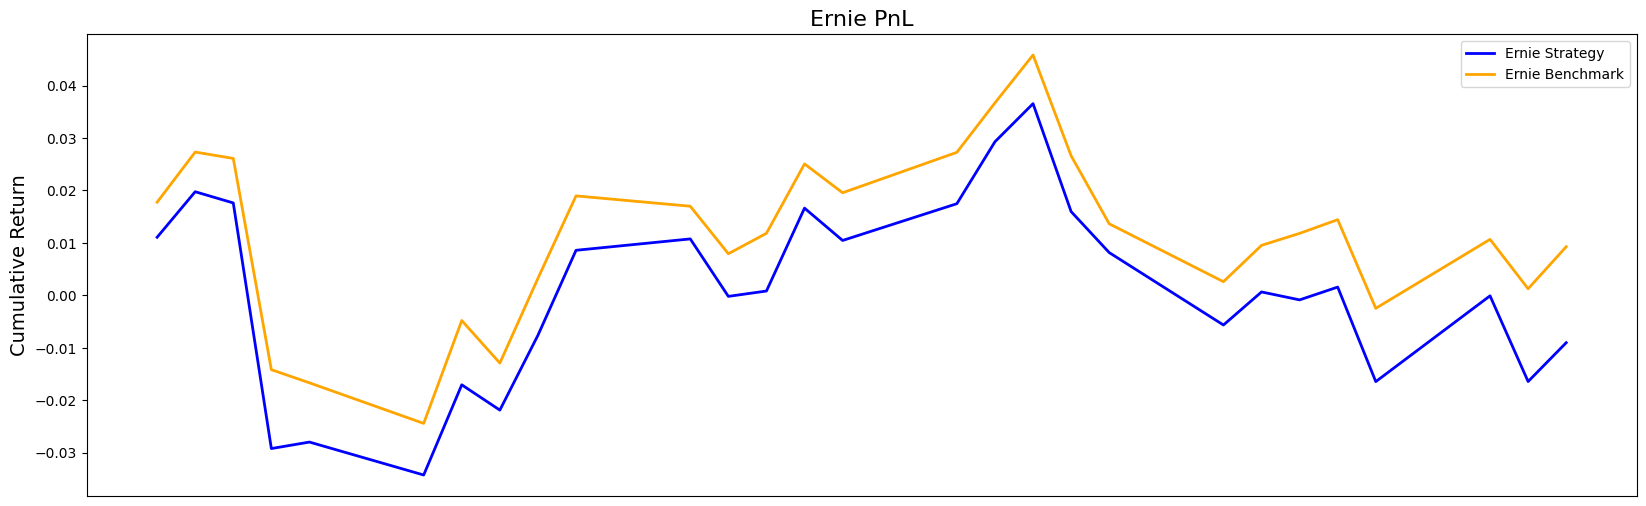

In [92]:
plot_pnl('Ernie', cumulative_returns_daily_without)

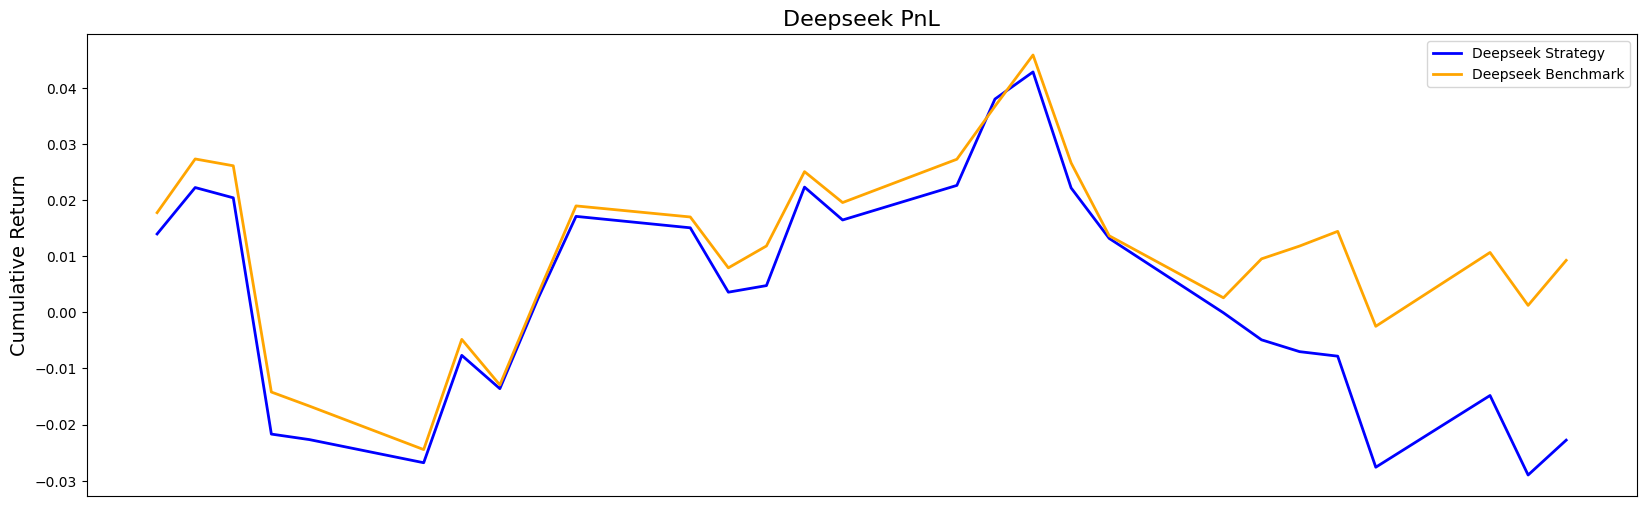

In [93]:
plot_pnl('Deepseek', cumulative_returns_daily_without)

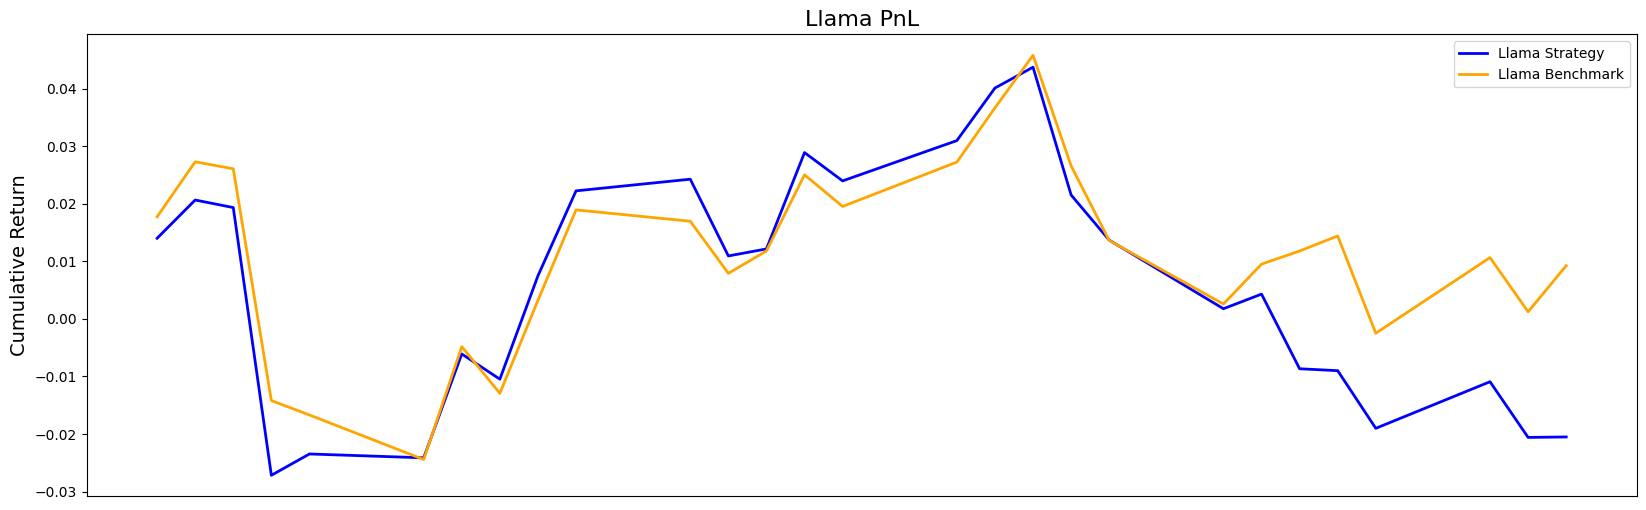

In [94]:
plot_pnl('Llama', cumulative_returns_daily_without)

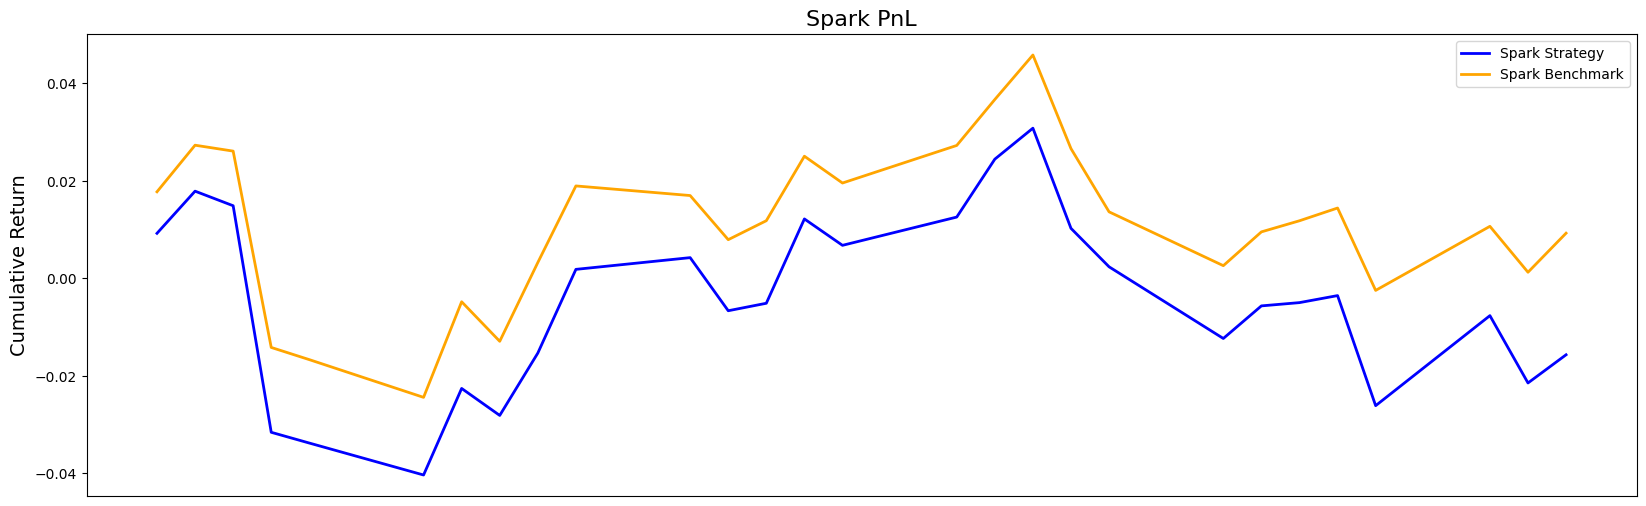

In [95]:
plot_pnl('Spark', cumulative_returns_daily_without)

In [96]:
metrics_table_daily_without = pd.DataFrame()
# 遍历每个策略，计算指标
for col in ['Ernie', 'Deepseek', 'Llama', 'Spark']:
    strategy_daily_return_without = cumulative_returns_daily_without[f'{col}_strategy'].diff().dropna()  # 计算每日收益率
    benchmark_daily_returns_without = cumulative_returns_daily_without[f'{col}_benchmark'].diff().dropna()  # 计算基准每日收益率
    
    metrics_without_daily = {
        'Max Drawdown': calculate_max_drawdown_daily(strategy_daily_return_without),
        'Sharpe Ratio': calculate_sharpe_ratio_daily(strategy_daily_return_without),
        'Win Rate': calculate_win_rate_daily(strategy_daily_return_without, benchmark_daily_returns_without),
        'Annualized Yield': calculate_annualized_yield_daily(strategy_daily_return_without),
        'Volatility': calculate_volatility_daily(strategy_daily_return_without)
    }
    metrics_table_daily_without[col] = pd.Series(metrics_without_daily)

In [97]:
# 打印指标分析表格
print(metrics_table_daily_without)

                     Ernie  Deepseek     Llama     Spark
Max Drawdown     -0.053694 -0.069957 -0.062874 -0.057675
Sharpe Ratio     -0.822019 -1.562530 -1.489283 -1.001147
Win Rate          0.333333  0.222222  0.333333  0.370370
Annualized Yield -0.192029 -0.306750 -0.292118 -0.228269
Volatility        0.014385  0.013817  0.013636  0.014640
